# New York Housing Data Set

Analysis by John Bonfardeci
jbonfardeci@definitivelogic.com
2018-12-11

In [1]:
require(lattice) # plotting lib required for car package
library(car) # includes vif(), scatterplotMatrix()
library(ggplot2) # plotting
#library(MASS)
library(dplyr) # common utilities for filtering
library(glmnet) # LASSO
library(caret) # includes methods for LASSO selection, trainControl CV k-fold

#install.packages('dummies')
library(dummies) # for converting categorical variables into indicator/dummy variables

Loading required package: lattice
Loading required package: carData
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'dplyr'

The following object is masked from 'package:car':

    recode

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

dummies-1.5.6 provided by Decision Patterns



## Question

**What variables in the data set predict the Full Market Value of a house?**

### Sample: Housing Data Set

In [2]:
# Import housing data set into dataframe instance.
df = read.csv("data/housing.csv")
head(df)

ID,Neighborhood,BuildingClassification,TotalUnits,YearBuilt,GrossSqFt,EstimatedGrossIncome,GrossIncomePerSqFt,EstimatedExpense,ExpensePerSqFt,NetOperatingIncome,FullMarketValue,MarketValuePerSqFt,Boro
1,FINANCIAL,R9-CONDOMINIUM,42,1920,36500,1332615,36.51,342005,9.37,990610,7300000,200.00,Manhattan
2,FINANCIAL,R4-CONDOMINIUM,78,1985,126420,6633257,52.47,1762295,13.94,4870962,30690000,242.76,Manhattan
3,FINANCIAL,RR-CONDOMINIUM,500,NA,554174,17310000,31.24,3543000,6.39,13767000,90970000,164.15,Manhattan
4,FINANCIAL,R4-CONDOMINIUM,282,1930,249076,11776313,47.28,2784670,11.18,8991643,67556006,271.23,Manhattan
5,TRIBECA,R4-CONDOMINIUM,239,1985,219495,10004582,45.58,2783197,12.68,7221385,54320996,247.48,Manhattan
6,TRIBECA,R4-CONDOMINIUM,133,1986,139719,5127687,36.70,1497788,10.72,3629899,26737996,191.37,Manhattan


### Explore: Univariate Analysis
* Look for skewness in histograms
    * A normally distributed histogram is bell-shaped with symmetry about the left and right tails.
    * If the right tail is smaller than the left tail, it's "skewed right."
    * If the left tail is smaller than the right tail, it's "skewed left."
    * If skewed, will log-transforming the variable make the distribution more normal (bell-shapped)?
* Look for outliers in the box plots.

In [3]:
# Display quantiles of variables in the housing data set.
summary(df)

       ID                          Neighborhood     BuildingClassification
 Min.   :   1.0   FLUSHING-NORTH         : 133   R2-CONDOMINIUM: 441      
 1st Qu.: 657.2   UPPER EAST SIDE (59-79): 123   R4-CONDOMINIUM:1883      
 Median :1313.5   HARLEM-CENTRAL         :  94   R9-CONDOMINIUM: 237      
 Mean   :1313.5   CHELSEA                :  88   RR-CONDOMINIUM:  65      
 3rd Qu.:1969.8   UPPER WEST SIDE (59-79):  87                            
 Max.   :2626.0   UPPER EAST SIDE (79-96):  78                            
                  (Other)                :2023                            
   TotalUnits        YearBuilt      GrossSqFt       EstimatedGrossIncome
 Min.   :   1.00   Min.   :1825   Min.   :    478   Min.   :    6424    
 1st Qu.:  15.00   1st Qu.:1926   1st Qu.:  18704   1st Qu.:  405180    
 Median :  30.00   Median :1986   Median :  38456   Median :  943901    
 Mean   :  70.18   Mean   :1967   Mean   :  82763   Mean   : 2640882    
 3rd Qu.:  75.00   3rd Qu.:2005   3

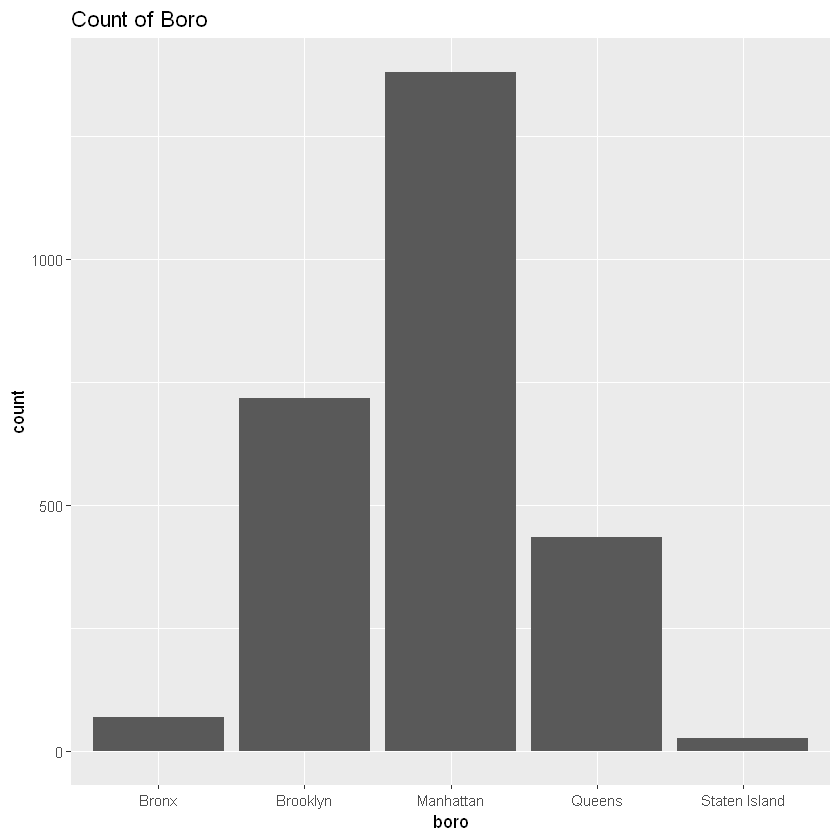

In [4]:
boro <- df$Boro

# counts
ggplot(data.frame(boro), aes(x=boro)) +
  geom_bar() + labs(title="Count of Boro")

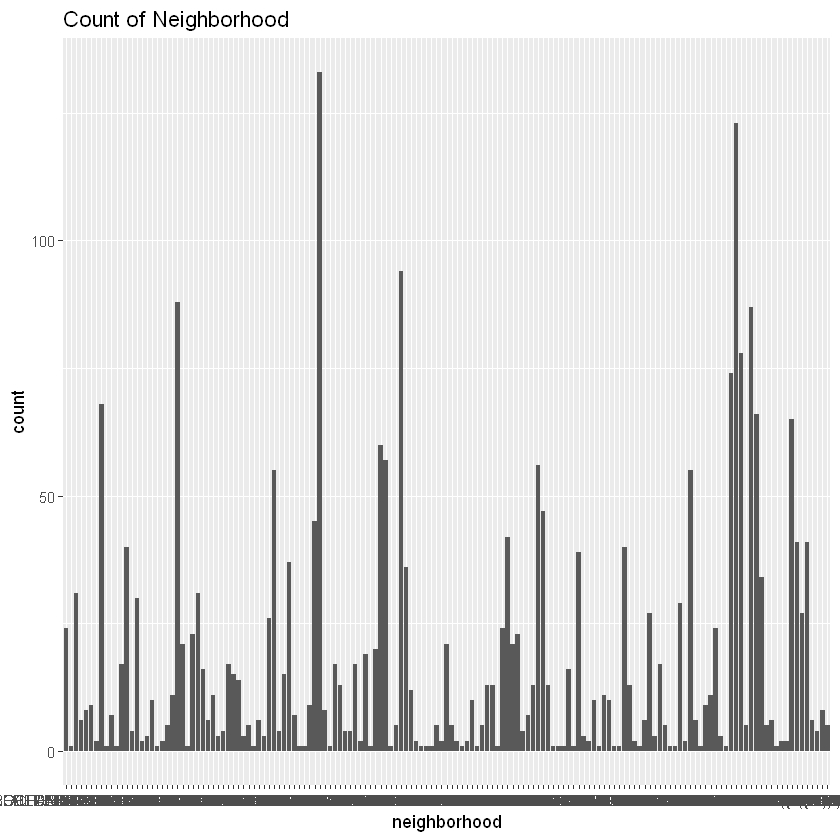

In [5]:
neighborhood <- df$Neighborhood
ggplot(data.frame(neighborhood), aes(x=neighborhood)) +
  geom_bar() + labs(title="Count of Neighborhood")

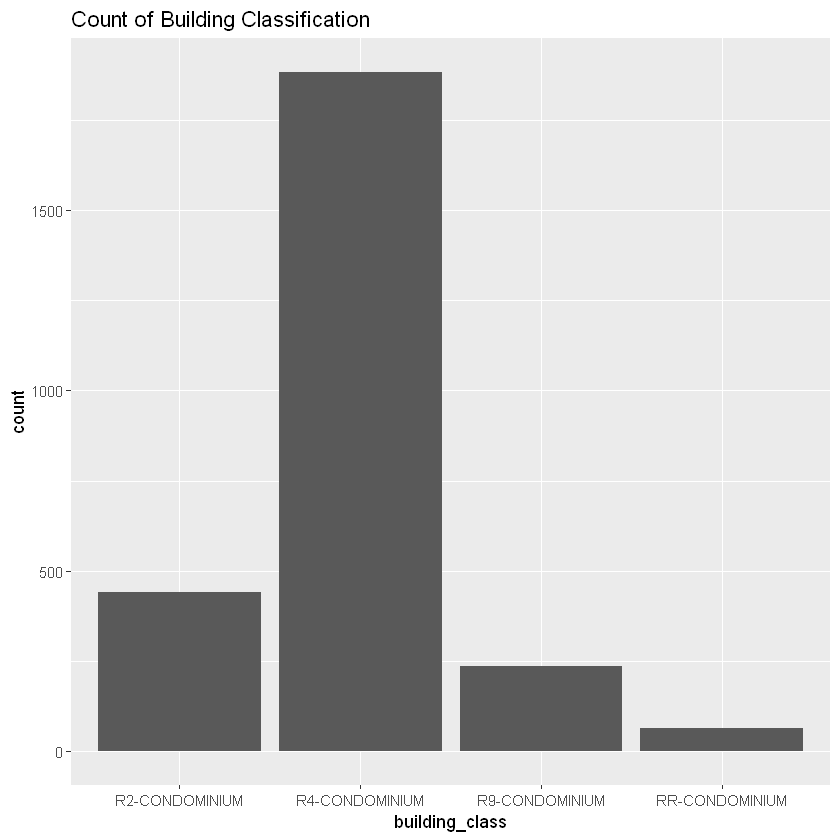

In [6]:
building_class <- df$BuildingClassification
ggplot(data.frame(building_class), aes(x=building_class)) +
  geom_bar() + labs(title="Count of Building Classification")

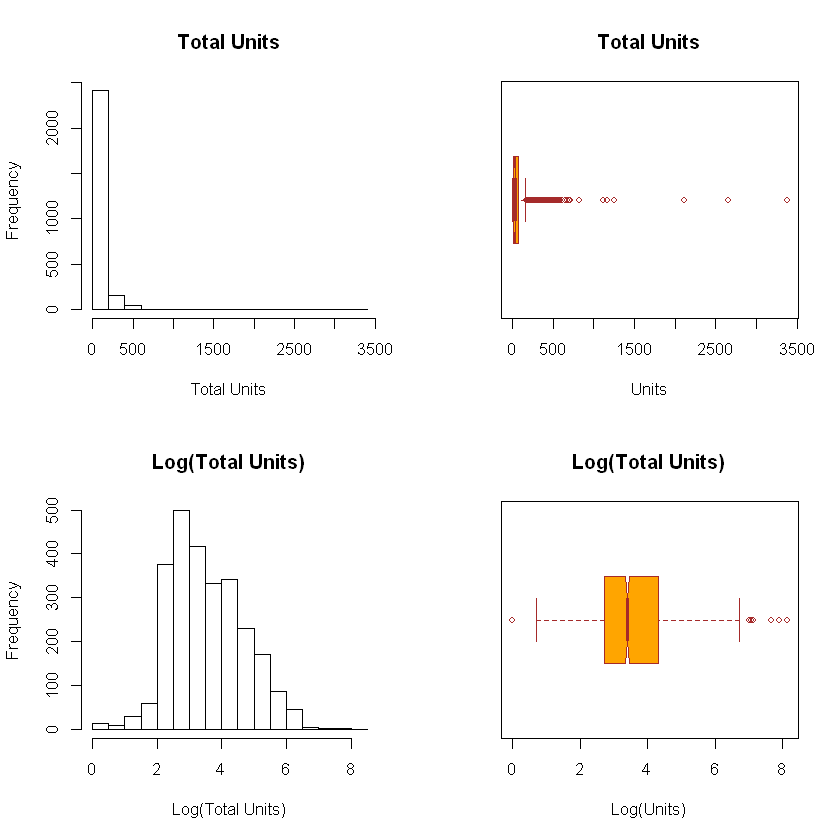

In [7]:
par(mfrow=c(2, 2))

hist(df$TotalUnits, main = "Total Units", xlab = "Total Units")

boxplot(df$TotalUnits, main = "Total Units",
    xlab = "Units",
    col = "orange",
    border = "brown",
    horizontal = TRUE,
    notch = TRUE)

df$logTotalUnits <- log(df$TotalUnits)

hist(df$logTotalUnits, main = "Log(Total Units)", xlab = "Log(Total Units)")

boxplot(df$logTotalUnits, main = "Log(Total Units)",
    xlab = "Log(Units)",
    col = "orange",
    border = "brown",
    horizontal = TRUE,
    notch = TRUE)

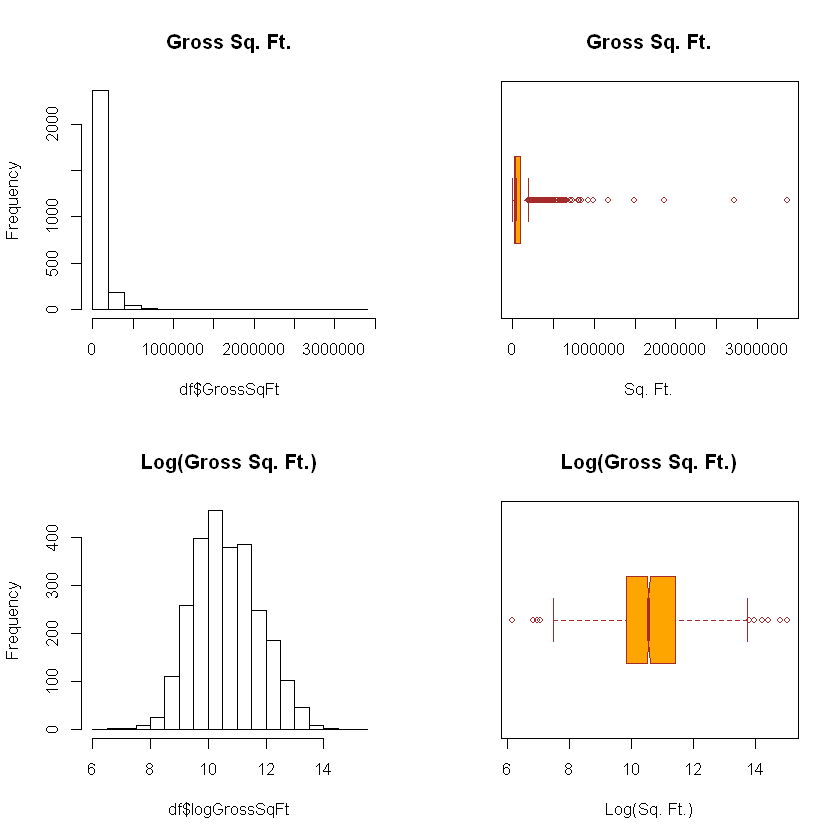

In [8]:
par(mfrow=c(2, 2))

hist(df$GrossSqFt, main = "Gross Sq. Ft.")

boxplot(df$GrossSqFt, main = "Gross Sq. Ft.",
    xlab = "Sq. Ft.",
    col = "orange",
    border = "brown",
    horizontal = TRUE,
    notch = TRUE)

df$logGrossSqFt <- log(df$GrossSqFt)

hist(df$logGrossSqFt, main = "Log(Gross Sq. Ft.)")

boxplot(df$logGrossSqFt, main = "Log(Gross Sq. Ft.)",
    xlab = "Log(Sq. Ft.)",
    col = "orange",
    border = "brown",
    horizontal = TRUE,
    notch = TRUE)

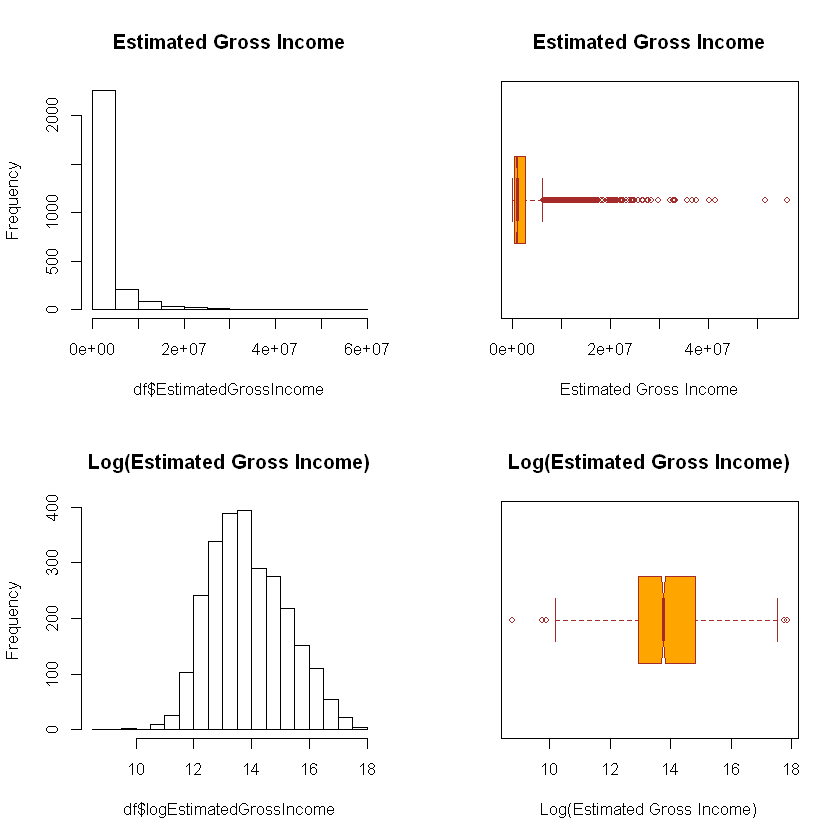

In [9]:
par(mfrow=c(2, 2))

hist(df$EstimatedGrossIncome, main = "Estimated Gross Income")

boxplot(df$EstimatedGrossIncome, main = "Estimated Gross Income",
    xlab = "Estimated Gross Income",
    col = "orange",
    border = "brown",
    horizontal = TRUE,
    notch = TRUE)

df$logEstimatedGrossIncome <- log(df$EstimatedGrossIncome)

hist(df$logEstimatedGrossIncome, main = "Log(Estimated Gross Income)")

boxplot(df$logEstimatedGrossIncome, main = "Log(Estimated Gross Income)",
    xlab = "Log(Estimated Gross Income)",
    col = "orange",
    border = "brown",
    horizontal = TRUE,
    notch = TRUE)

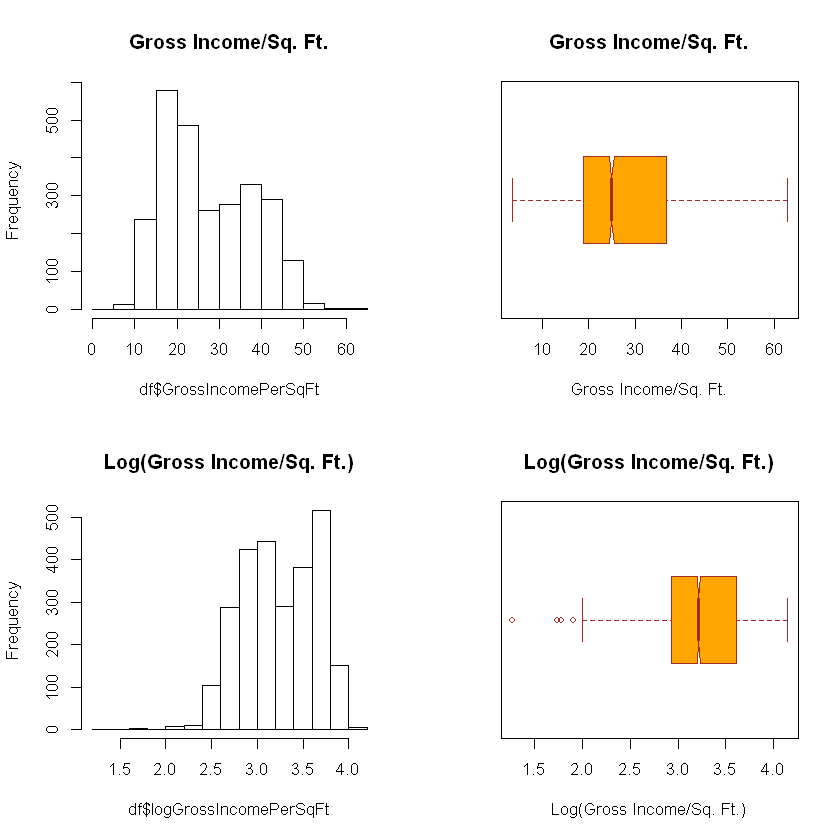

In [10]:
par(mfrow=c(2, 2))

hist(df$GrossIncomePerSqFt, main = "Gross Income/Sq. Ft.")

boxplot(df$GrossIncomePerSqFt, main = "Gross Income/Sq. Ft.",
    xlab = "Gross Income/Sq. Ft.",
    col = "orange",
    border = "brown",
    horizontal = TRUE,
    notch = TRUE)

df$logGrossIncomePerSqFt <- log(df$GrossIncomePerSqFt)

hist(df$logGrossIncomePerSqFt, main = "Log(Gross Income/Sq. Ft.)")

boxplot(df$logGrossIncomePerSqFt, main = "Log(Gross Income/Sq. Ft.)",
    xlab = "Log(Gross Income/Sq. Ft.)",
    col = "orange",
    border = "brown",
    horizontal = TRUE,
    notch = TRUE)

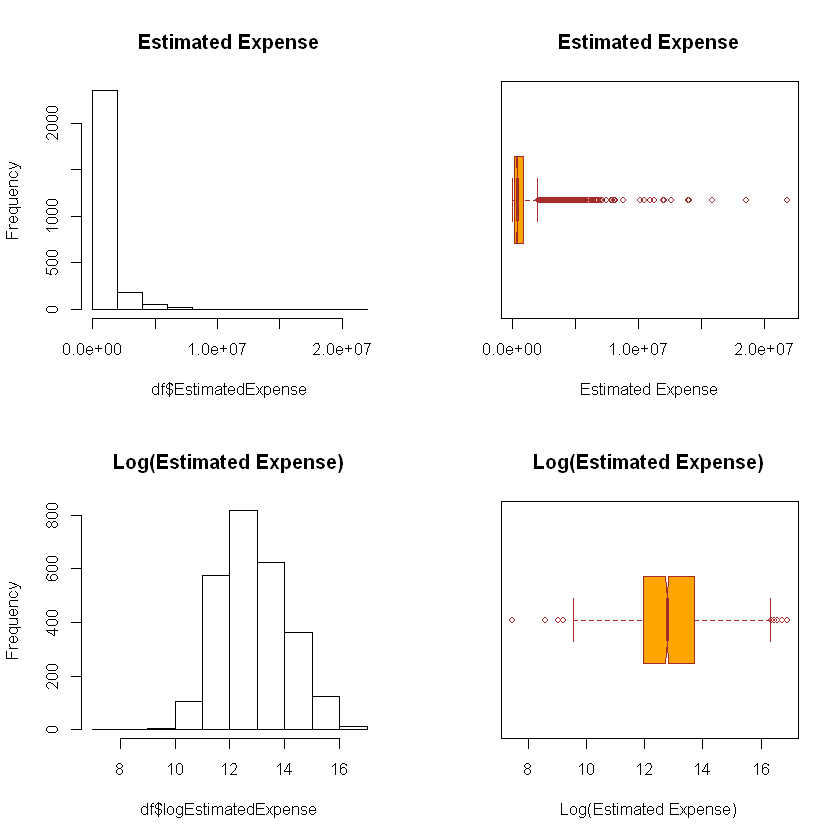

In [11]:
par(mfrow=c(2, 2))

hist(df$EstimatedExpense, main = "Estimated Expense")

boxplot(df$EstimatedExpense, main = "Estimated Expense",
    xlab = "Estimated Expense",
    col = "orange",
    border = "brown",
    horizontal = TRUE,
    notch = TRUE)

df$logEstimatedExpense <- log(df$EstimatedExpense)

hist(df$logEstimatedExpense, main = "Log(Estimated Expense)")

boxplot(df$logEstimatedExpense, main = "Log(Estimated Expense)",
    xlab = "Log(Estimated Expense)",
    col = "orange",
    border = "brown",
    horizontal = TRUE,
    notch = TRUE)

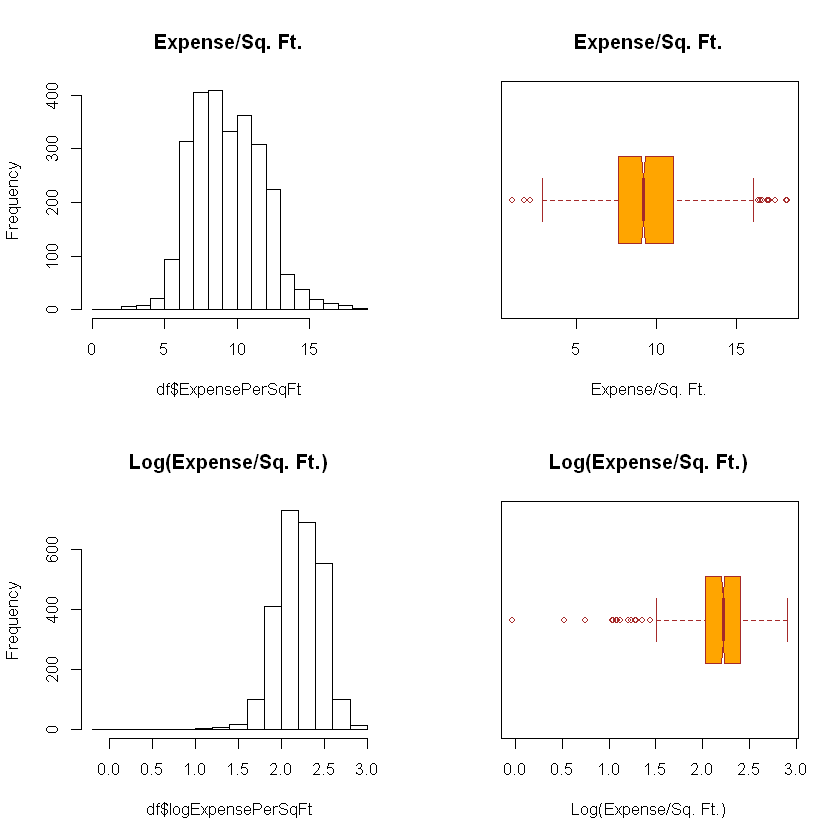

In [12]:
par(mfrow=c(2, 2))

hist(df$ExpensePerSqFt, main = "Expense/Sq. Ft.")

boxplot(df$ExpensePerSqFt, main = "Expense/Sq. Ft.",
    xlab = "Expense/Sq. Ft.",
    col = "orange",
    border = "brown",
    horizontal = TRUE,
    notch = TRUE)

df$logExpensePerSqFt <- log(df$ExpensePerSqFt)

hist(df$logExpensePerSqFt, main = "Log(Expense/Sq. Ft.)")

boxplot(df$logExpensePerSqFt, main = "Log(Expense/Sq. Ft.)",
    xlab = "Log(Expense/Sq. Ft.)",
    col = "orange",
    border = "brown",
    horizontal = TRUE,
    notch = TRUE)

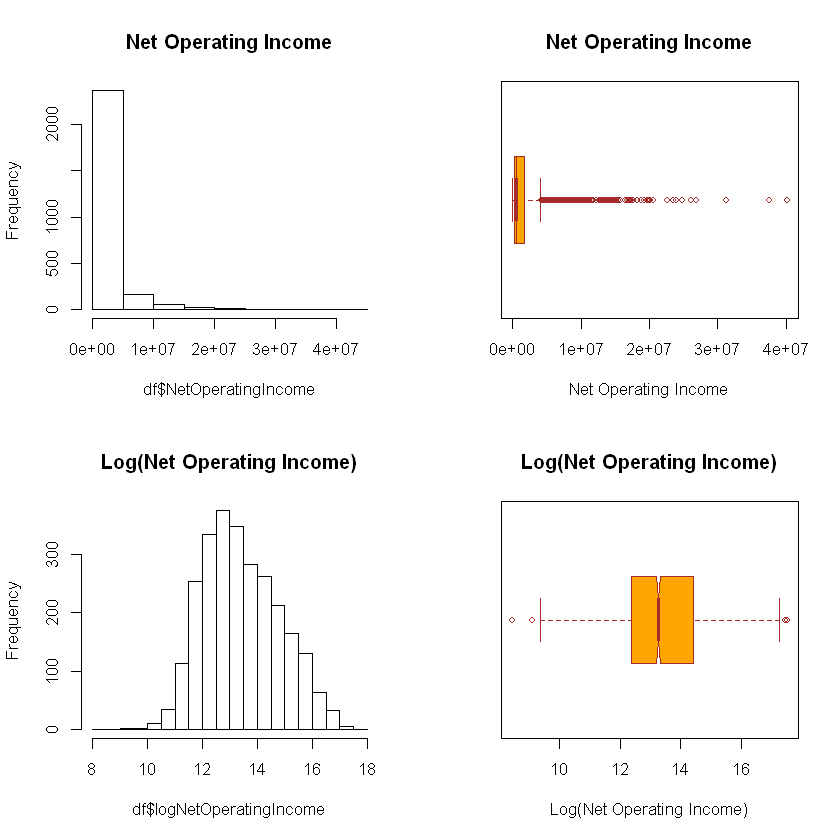

In [13]:
par(mfrow=c(2, 2))

hist(df$NetOperatingIncome, main = "Net Operating Income")

boxplot(df$NetOperatingIncome, main = "Net Operating Income",
    xlab = "Net Operating Income",
    col = "orange",
    border = "brown",
    horizontal = TRUE,
    notch = TRUE)

df$logNetOperatingIncome <- log(df$NetOperatingIncome)

hist(df$logNetOperatingIncome, main = "Log(Net Operating Income)")

boxplot(df$logNetOperatingIncome, main = "Log(Net Operating Income)",
    xlab = "Log(Net Operating Income)",
    col = "orange",
    border = "brown",
    horizontal = TRUE,
    notch = TRUE)

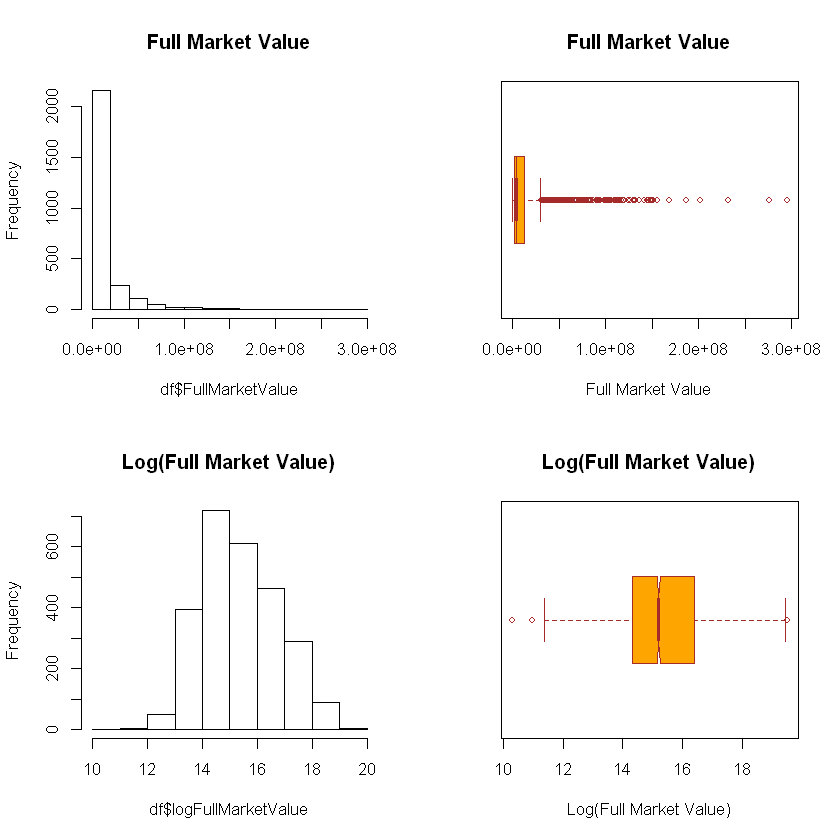

In [14]:
par(mfrow=c(2, 2))

hist(df$FullMarketValue, main = "Full Market Value")

boxplot(df$FullMarketValue, main = "Full Market Value",
    xlab = "Full Market Value",
    col = "orange",
    border = "brown",
    horizontal = TRUE,
    notch = TRUE)

df$logFullMarketValue <- log(df$FullMarketValue)

hist(df$logFullMarketValue, main = "Log(Full Market Value)")

boxplot(df$logFullMarketValue, main = "Log(Full Market Value)",
    xlab = "Log(Full Market Value)",
    col = "orange",
    border = "brown",
    horizontal = TRUE,
    notch = TRUE)

## Multivariate Analysis

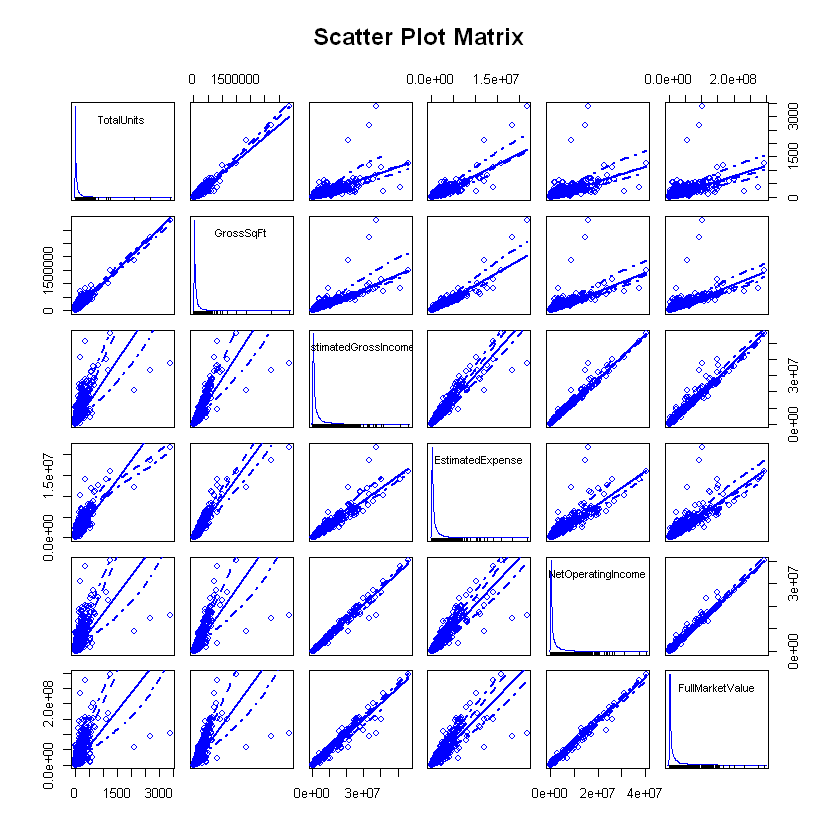

In [15]:
# Drop non-numerical variables.
numerical <- subset(df, select = -c(ID, Neighborhood, BuildingClassification, Boro, YearBuilt, 
                                    logTotalUnits, logGrossSqFt, logEstimatedGrossIncome, logGrossIncomePerSqFt,
                                    logEstimatedExpense, logExpensePerSqFt, logNetOperatingIncome, logFullMarketValue,
                                    logGrossIncomePerSqFt, GrossIncomePerSqFt, logExpensePerSqFt, ExpensePerSqFt, MarketValuePerSqFt)) 

# Display a scatter plot matrix to identify linear relationships between variables.
scatterplotMatrix(numerical, main="Scatter Plot Matrix") 
#spread=FALSE, smoother.args=list(lty=2), 

In [16]:
# Show Correlation Matrix
cor(numerical)
# Positive numbers indicate a linear relationship between two variables.
# Numbers ~0 indicate little to no relationship.
# Numbers < 0 indicate inverse correlation.

,TotalUnits,GrossSqFt,EstimatedGrossIncome,EstimatedExpense,NetOperatingIncome,FullMarketValue
TotalUnits,1.0000000,0.9577540,0.7557462,0.8689732,0.6854765,0.6616389
GrossSqFt,0.9577540,1.0000000,0.8560584,0.9433135,0.7945727,0.7747158
EstimatedGrossIncome,0.7557462,0.8560584,1.0000000,0.9576951,0.9918870,0.9829985
EstimatedExpense,0.8689732,0.9433135,0.9576951,1.0000000,0.9133413,0.8982289
NetOperatingIncome,0.6854765,0.7945727,0.9918870,0.9133413,1.0000000,0.9940990
FullMarketValue,0.6616389,0.7747158,0.9829985,0.8982289,0.9940990,1.0000000


### Split the dataset into 70% training and 30% validation sets. 

In [17]:

# 70% of sample
sample_size <- floor(0.7 * nrow(df))

# set seed to make partitions reproducible.
set.seed(42)
train_ind <- sample( seq_len(nrow(df)), size = sample_size)

# Get training set
train_data <- df[train_ind, ]

# Get validation set
validation <- df[-train_ind, ]


### Model

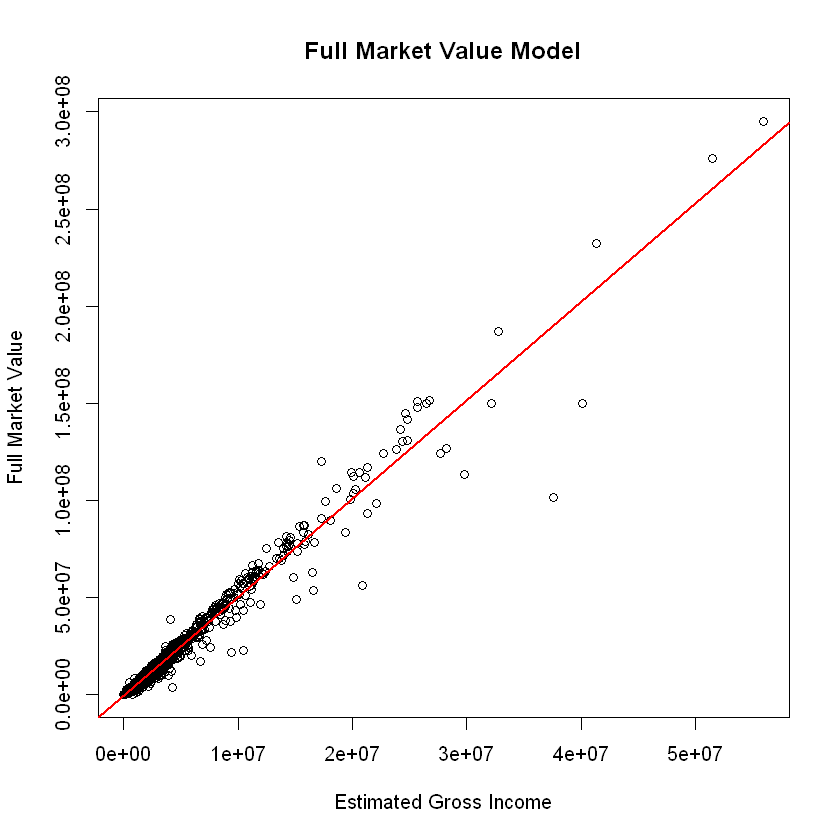

In [18]:
# Fit linear regression model with lm()
fit <- lm(FullMarketValue ~ EstimatedGrossIncome, data = train_data)
plot(train_data$EstimatedGrossIncome, train_data$FullMarketValue, xlab = "Estimated Gross Income", ylab = "Full Market Value", 
     main = "Full Market Value Model")
abline(fit, col = "red", lty=1, lwd=2)

### Assess

In [19]:
summary(fit)
bic = BIC(fit)
paste("BIC", ":", BIC(fit))


Call:
lm(formula = FullMarketValue ~ EstimatedGrossIncome, data = train_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-87921116   -428838    134054    563358  32649371 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -3.901e+05  1.165e+05   -3.35 0.000824 ***
EstimatedGrossIncome  5.061e+00  2.189e-02  231.26  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4350000 on 1836 degrees of freedom
Multiple R-squared:  0.9668,	Adjusted R-squared:  0.9668 
F-statistic: 5.348e+04 on 1 and 1836 DF,  p-value: < 2.2e-16


[1] "BIC : 61427.1495144472"

### Asjusted R-squared is .97 meaning the model accounts for 97% of the variance in EstimatedGrossIncome.

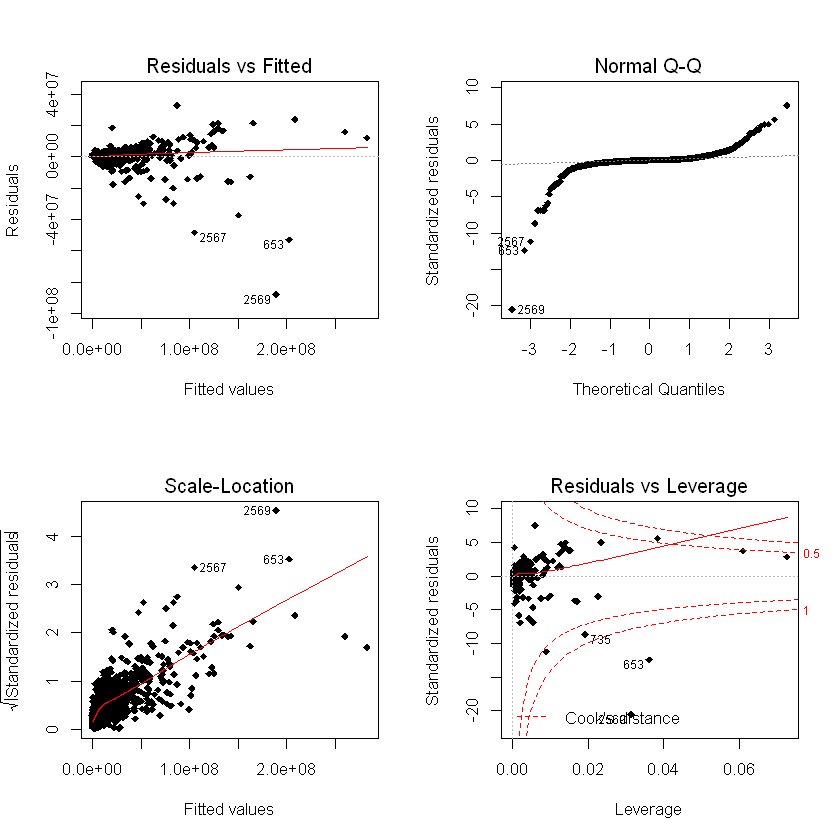

In [20]:
# Show plot of standardized residuals by the fitted values. If non-constant variance, 
# increasing variance from left to right, the model is not valid.
par(mfrow=c(2,2))
plot(fit, pch = 18)

### Is the model valid?
* **Linearity** - (Top Left)
    * If Y is linearly related to X, there should be no relationship between the residuals and th efitted values. 
    * The scatter plot should show be random noise.
    * Since there's increasing variance from left to right, the linearity assumption is violated.

* **Normality** - (Top Right)
    * If Y is normally distrubuted, then the residual values should be normally distributed with a mean of 0.
    * Q-Q plot is a probability plot of the std. residuals against the values that would be expected under normality.
    * The points do not fall on this line, so the normality assumption is violated.

* **Homoscedasticity** (Bottom Left)
    * A plot of the std. residuals against the fitted values should show constant variance (random noise) about a horizontal line.
    * Assumption of Homoscedasticity is violated.
    
* **Outliers** - Std. Residuals against Cook's Distance
    * Observations with Std. Residual < -3 or > 3 have a *high leverage* value. They're outliers.
    * Observations that have a Cook's Distance value > 1 are overly influential.
    
**The model is INVALID!**

## How to we fix an invalid model?
We know from the histograms that both the response variable and the predictor are not normally distributed - they're both skewed. We know that log-transforming can make a variable normally distributed, so we try log-transforming the response variable and the predictor.

### Modify

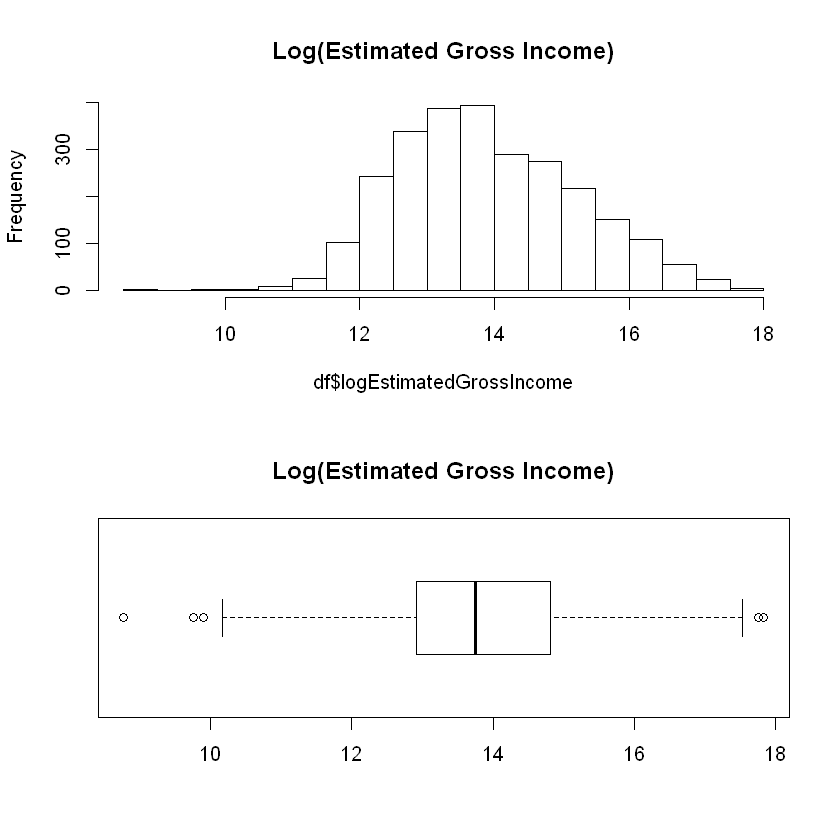

In [21]:
# Log-transform the X
par(mfrow=c(2,1))
hist(df$logEstimatedGrossIncome, main = "Log(Estimated Gross Income)")
boxplot(df$logEstimatedGrossIncome, main = "Log(Estimated Gross Income)", horizontal = TRUE)
# The histogram displayed shows a more normal distribution than the non-log-transformed version.

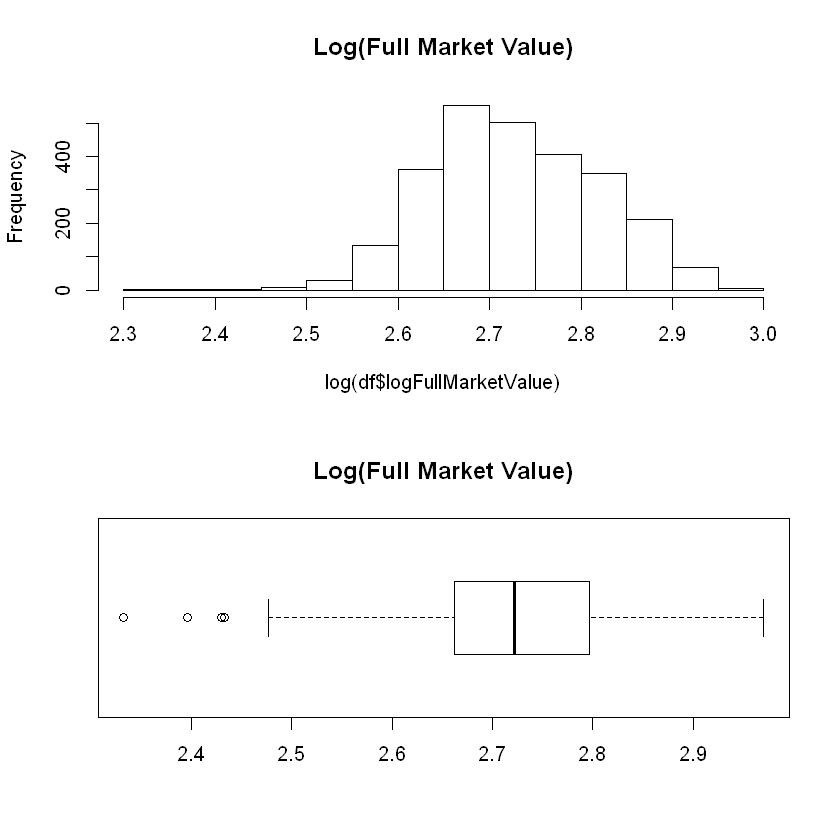

In [22]:
# Log-transform the Y
par(mfrow=c(2,1))
hist(log(df$logFullMarketValue), main = "Log(Full Market Value)")
boxplot(log(df$logFullMarketValue), main = "Log(Full Market Value)", horizontal = TRUE)
# The histogram displayed shows a more normal distribution than the non-log-transformed version.

### Model: Re-fit the model with the log-transformed variables.

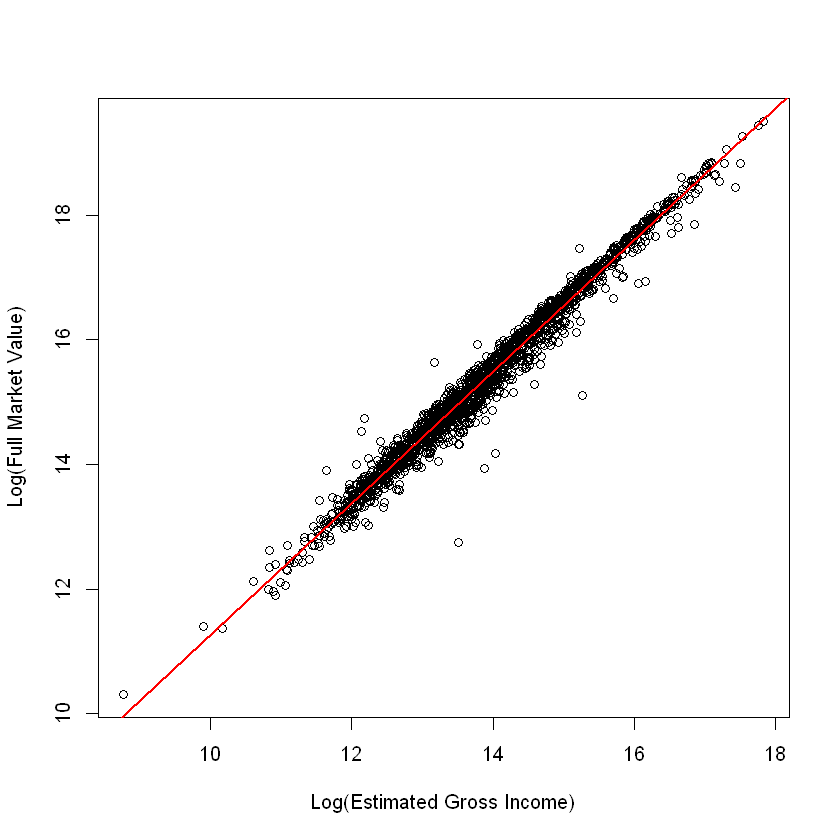

In [23]:
# Fit a new model with the log-transformed versions.
log_fit <- lm(logFullMarketValue ~ logEstimatedGrossIncome, data = train_data)
plot(train_data$logEstimatedGrossIncome, train_data$logFullMarketValue, xlab = "Log(Estimated Gross Income)", ylab = "Log(Full Market Value)")
abline(log_fit, col = "red", lty=1, lwd=2)

### Assess

Notice the elliptical symmetry about the regression line.

In [24]:
summary(log_fit)
bic2 <- BIC(log_fit)
paste("BIC 1", ":", bic)
paste("BIC 2", ":", bic2)


Call:
lm(formula = logFullMarketValue ~ logEstimatedGrossIncome, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.23186 -0.09589  0.02921  0.12605  1.15874 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             0.724282   0.051116   14.17   <2e-16 ***
logEstimatedGrossIncome 1.054677   0.003666  287.72   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2062 on 1836 degrees of freedom
Multiple R-squared:  0.9783,	Adjusted R-squared:  0.9783 
F-statistic: 8.278e+04 on 1 and 1836 DF,  p-value: < 2.2e-16


[1] "BIC 1 : 61427.1495144472"

[1] "BIC 2 : -567.226340361544"

### Summary of Fit
* Adjusted R-squared is 0.98 - `logEstimatedGrossIncome` accounts for 98% of the variance in `logFullMarketValue`.
* BIC (Bayesian Information Criterion) decreased from 60847 to -866.7 Lower is better.
* The p-value for the y-intercept is significant (p-value < 0.05)
* Predictor `logEstimatedGrossIncome` is significant (p-value < 0.05)

### Do we have constant variance?

In [25]:
# Test for constant variance
ncvTest(log_fit)

Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.2027802, Df = 1, p = 0.65249

The p-value from `ncvTest()` is **not significant** (> 0.05), suggesting we've met the assumuption of constant variance.
With the exception of outliers, it would appear we've **met the assumption of constant variance**.

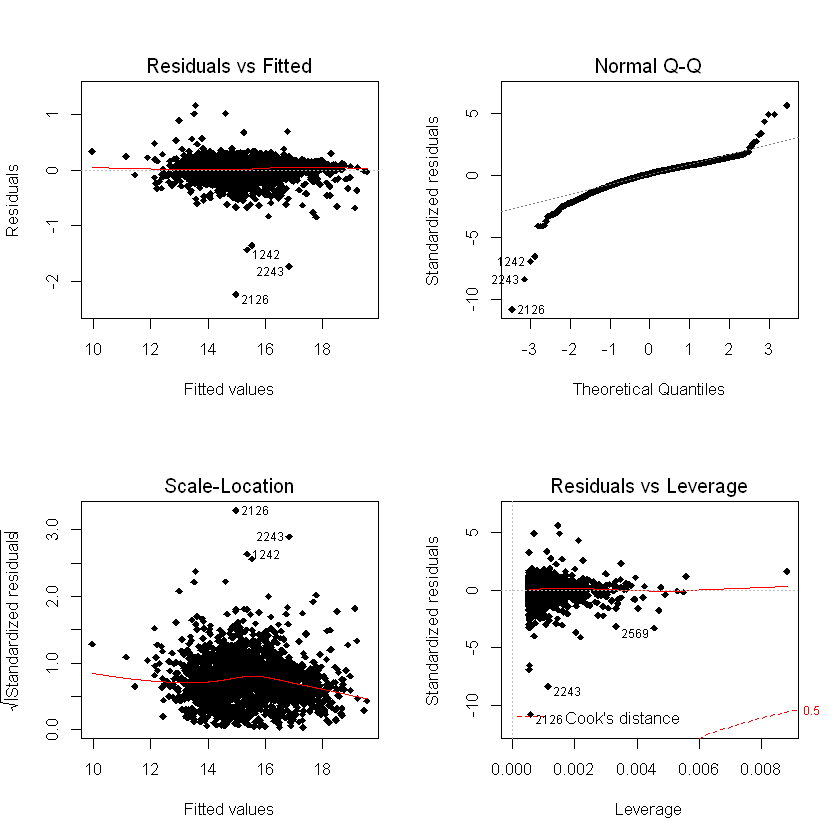

In [26]:
# Show plot of residuals by the fitted values. Do we have constant variance?
par(mfrow=c(2,2))
plot(log_fit, pch = 18)

In [27]:
summary(log_fit)


Call:
lm(formula = logFullMarketValue ~ logEstimatedGrossIncome, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.23186 -0.09589  0.02921  0.12605  1.15874 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             0.724282   0.051116   14.17   <2e-16 ***
logEstimatedGrossIncome 1.054677   0.003666  287.72   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2062 on 1836 degrees of freedom
Multiple R-squared:  0.9783,	Adjusted R-squared:  0.9783 
F-statistic: 8.278e+04 on 1 and 1836 DF,  p-value: < 2.2e-16


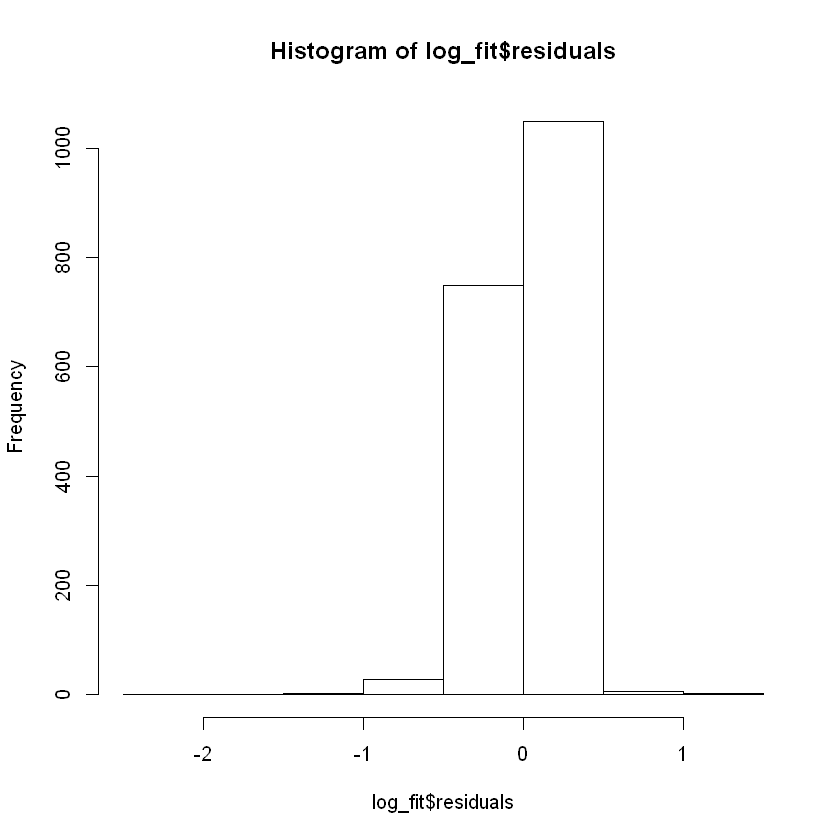

In [28]:
hist(log_fit$residuals)

### Formula
Based on the `summary()` output above, we have the Y-intercept (Beta 0) and coefficient of Beta 1. 

Our formula is:

`Y-hat = 0.700055 + 1.056609(X1), where Y-hat = Log(FullMarketValue), X1 = Log(EstimatedGrossIncome)`

### Interpretaion of the Model

When log-transforming a dependent variable and/or predictor, our interpretation of the model will change.
Normally an in/decrease in one unit of X corresponds to an in/decrease in one unit of Y.
When dealing with log-transforms for both Y and X, the interpretation is:

**A 1% increase in Log(EstimatedGrossIncome) is predicted to increase Log(FullMarketValue) by 1.057%.**

## Outliers

In [29]:
outlierTest(log_fit)

       rstudent unadjusted p-value Bonferonni p
2126 -11.186134         3.7925e-28   6.9706e-25
2243  -8.537297         2.8354e-17   5.2115e-14
1242  -7.027126         2.9607e-12   5.4417e-09
1171  -6.629889         4.4043e-11   8.0951e-08
1666   5.670687         1.6489e-08   3.0306e-05
85     4.954884         7.9026e-07   1.4525e-03
1322   4.931439         8.8988e-07   1.6356e-03
2424   4.345193         1.4677e-05   2.6976e-02

## Leverage Points
* A *leverage point* is a point whose x-value is distant from the other x-values.
* Data points which exercise considerable influence on the fitted model.
* Not all leverage points are bad leverage points.
* All bad leverage points are outliers but not all outliers are bad leverage points.
* We'll determine if a leverage point is bad using Cook's Distance

### Standardized Residual (aka, Studentized Residual)
* a residual divided by it's standard deviation.
* As a rule, a studentized residual < -3 or > 3 is a bad leverage point.
* In very large data sets, a more appropriate cuttoff is < -4 or > 4, or even < -5 or > 5

In [30]:
# Get studentized residuals < -3 or > 3
stud_resid <- rstandard(log_fit)

# Show rows where Std. Resid. < -3 or > 3
train_data$StdResid <- stud_resid
r <- filter(train_data, (train_data$StdResid < -3 | train_data$StdResid > 3))

### Cook's Distance
* R. Dennis Cook. University of Minnesota. 1977. (https://en.wikipedia.org/wiki/R._Dennis_Cook)
* Cook's Distance is a composite measure of outlyingness and leverage.
* Rule of thumb (They're more like guidelines.):
    * Cook's Distance > 1 - investigate. Adding a dummy variable to these cases can change regression estimates.
    * Cases with Cook's Distance > 0.5 should also be investigated.
    * Also look for gaps om the values of Cook's distance and not just whether values exceed the suggested cuttoff. 

[1] "There are no points with a Cook's D > 1."


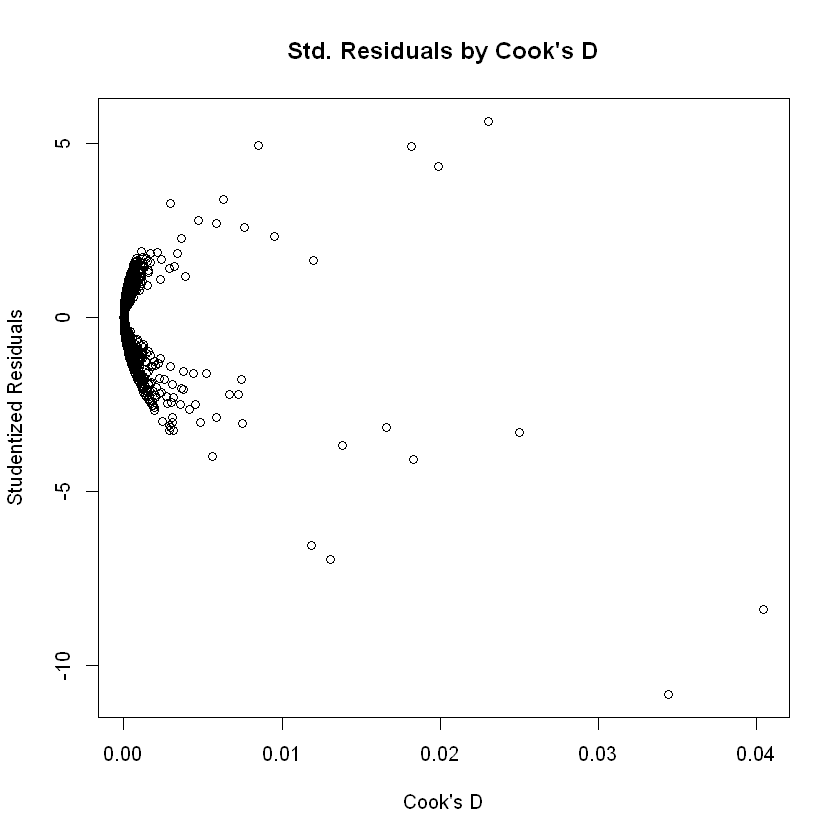

In [31]:
# Get Cook's Distance points where > 1
getCooksD <- function(fit){
    stud_resid <- rstandard(fit)
    cooks_dist <- cooks.distance(fit)
    influential_points <- cooks_dist[cooks_dist >= 1] # Filter on points > 1 with a list comprehension.
    influential_points # Display influential points
    if( length(influential_points) == 0){
        print("There are no points with a Cook's D > 1.")
    }

    plot(x = cooks_dist, y = stud_resid, main="Std. Residuals by Cook's D", xlab="Cook's D", ylab = "Studentized Residuals")
}

getCooksD(log_fit)

Though there are observations with studentized residuals less than -3 and greater than 3, we do not need to worry that they're bad leverage points since none of the Cook's Distance values exceed 1. However those with a Cook's D > 0.5 should be investigated. Results of `outlierTest()` in this case should not be cause for concern.

## How do we handle bad leverage points?
Leverage points need to be investigated but not removed from a model. Doing so can cause us to lose important observations.

To negate the influence of a a bad leverage point and improve the model's predictive accuracy, we add what's called a "dummy variable" or "indicator variable." This variable has a value of "1" if it's a bad leverage point, and a "0" otherwise. Dummy variables will cause the beta estimates in the equation to change. This means if there's a bad leverage point in the training set, it won't change the way the model predicts new observations.


Call:
lm(formula = logFullMarketValue ~ logEstimatedGrossIncome, data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2327 -0.0973  0.0236  0.1205  5.8510 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)              0.62542    0.06122   10.21   <2e-16 ***
logEstimatedGrossIncome  1.06206    0.00439  241.90   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.247 on 1836 degrees of freedom
Multiple R-squared:  0.9696,	Adjusted R-squared:  0.9696 
F-statistic: 5.852e+04 on 1 and 1836 DF,  p-value: < 2.2e-16


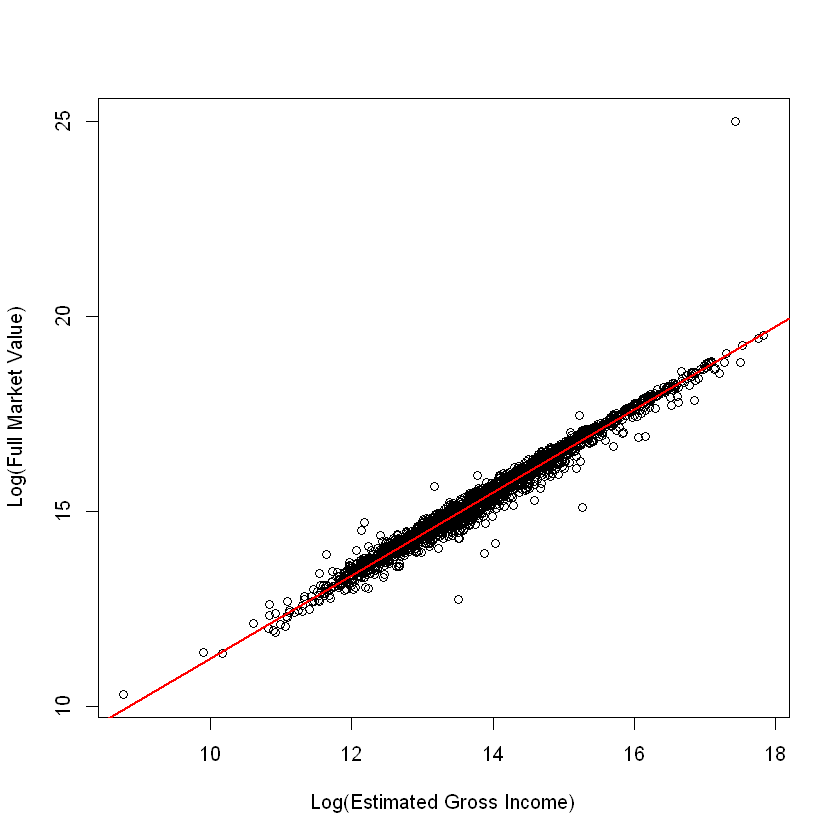

In [32]:
# Artificially set a bad leverage point for this example.
train_data$logFullMarketValue[train_data$ID == 2569 ] <- 25

log_fit2 <- lm(logFullMarketValue ~ logEstimatedGrossIncome, data = train_data)
plot(train_data$logEstimatedGrossIncome, train_data$logFullMarketValue, xlab = "Log(Estimated Gross Income)", ylab = "Log(Full Market Value)")
abline(log_fit2, col = "red", lty=1, lwd=2)

summary(log_fit2)

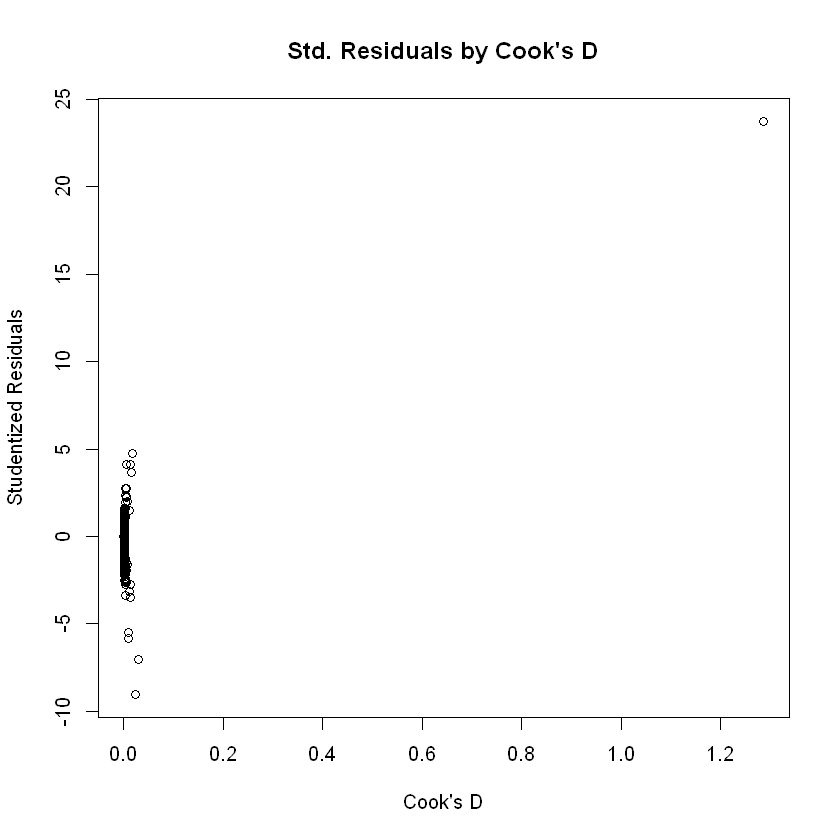

In [33]:
# Now we have a bad leverage point.
getCooksD(log_fit2)

In [34]:
# We add a dummy variable = 1 if Cook's D >= 1.
train_data$CooksD <- cooks.distance(log_fit2)

# Create a Dummy colunm with default value 0.
train_data$Overpriced <- rep(0, nrow(train_data))

# Set the dummy == 1 on the bad leverage point.
train_data$Overpriced[train_data$ID == 2569 ] <- 1

dfx = data.frame(train_data)
sorted = dfx[order(-dfx$Overpriced),]
head(sorted)

,ID,Neighborhood,BuildingClassification,TotalUnits,YearBuilt,GrossSqFt,EstimatedGrossIncome,GrossIncomePerSqFt,EstimatedExpense,ExpensePerSqFt,...,logGrossSqFt,logEstimatedGrossIncome,logGrossIncomePerSqFt,logEstimatedExpense,logExpensePerSqFt,logNetOperatingIncome,logFullMarketValue,StdResid,CooksD,Overpriced
2569,2569,PARKCHESTER,R4-CONDOMINIUM,3378,1933,3364977,37553143,11.16,21771401,6.47,...,15.028932,17.44127,2.412336,16.89611,1.867176,16.57436,25.00000,-3.3102371,1.287087e+00,1
2609,2609,TOMPKINSVILLE,R4-CONDOMINIUM,147,1965,159096,1942562,12.21,905256,5.69,...,11.977263,14.47952,2.502255,13.71597,1.738710,13.85214,15.55561,-2.1338409,1.080882e-03,0
2369,2369,FLUSHING-NORTH,R4-CONDOMINIUM,18,2003,18730,412060,22.00,113878,6.08,...,9.837882,12.92892,3.091042,11.64288,1.805005,12.60546,14.47251,0.5452381,9.164004e-05,0
1177,1177,HARLEM-EAST,R2-CONDOMINIUM,12,1910,7690,196403,25.54,83821,10.90,...,8.947676,12.18792,3.240246,11.33644,2.388763,11.63144,13.61217,0.1628881,2.155572e-05,0
1098,1098,UPPER EAST SIDE (79-96),R4-CONDOMINIUM,29,1980,23232,941825,40.54,278784,12.00,...,10.053286,13.75557,3.702289,12.53819,2.484907,13.40459,15.42675,0.9447818,1.663676e-04,0
1252,1252,MANHATTAN VALLEY,R4-CONDOMINIUM,88,1902,88060,2345038,26.63,891167,10.12,...,11.385774,14.66781,3.282038,13.70029,2.314514,14.18974,16.16803,-0.1264219,7.609778e-06,0


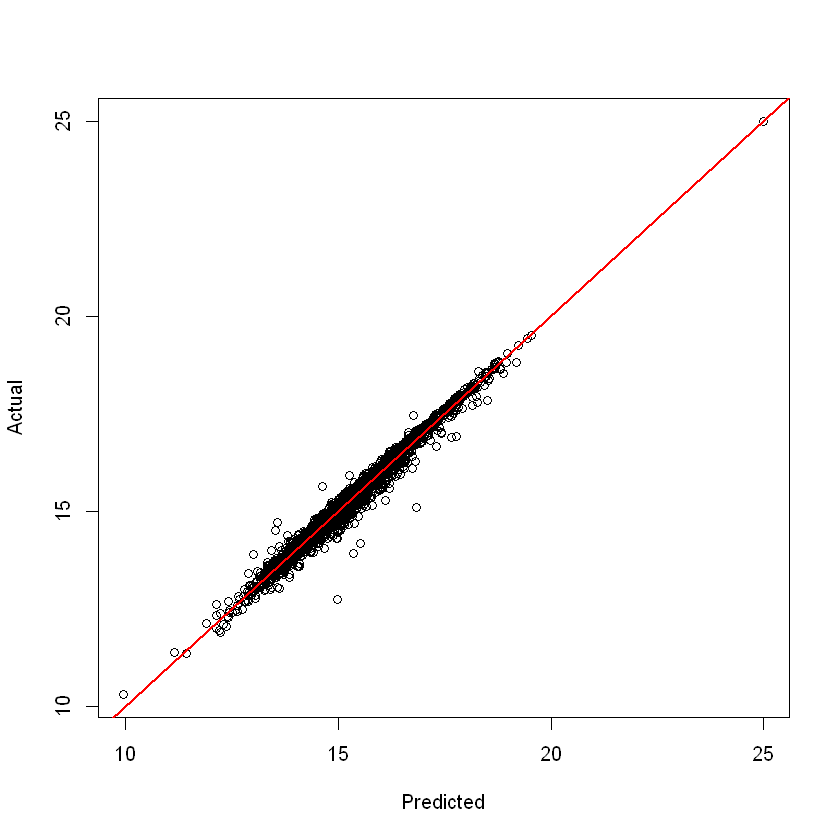

In [35]:
# After adding the dummy variable, we see the regression line is no longer affected.
log_fit3 <- lm(logFullMarketValue ~ logEstimatedGrossIncome + Overpriced, data = train_data)
train_data$Yhat <- predict(log_fit3, train_data)

plot(train_data$Yhat, train_data$logFullMarketValue, xlab = "Predicted", ylab = "Actual")
abline(lm(logFullMarketValue ~ Yhat, data = train_data), col = "red", lty=1, lwd=2)

In [36]:
# The coefficients after adding the dummy variable are not much different than the previous fit.
# Take note of the small differences in the Intercepts and estimated for `logEstimatedGrossIncome`.
print("Fit Without Bad Leverage Point")
summary(log_fit2)

print("Fit With Bad Leverage Point")
summary(log_fit3)

[1] "Fit Without Bad Leverage Point"



Call:
lm(formula = logFullMarketValue ~ logEstimatedGrossIncome, data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2327 -0.0973  0.0236  0.1205  5.8510 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)              0.62542    0.06122   10.21   <2e-16 ***
logEstimatedGrossIncome  1.06206    0.00439  241.90   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.247 on 1836 degrees of freedom
Multiple R-squared:  0.9696,	Adjusted R-squared:  0.9696 
F-statistic: 5.852e+04 on 1 and 1836 DF,  p-value: < 2.2e-16


[1] "Fit With Bad Leverage Point"



Call:
lm(formula = logFullMarketValue ~ logEstimatedGrossIncome + Overpriced, 
    data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.23195 -0.09567  0.02843  0.12549  1.15968 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             0.713974   0.051072   13.98   <2e-16 ***
logEstimatedGrossIncome 1.055446   0.003663  288.13   <2e-16 ***
Overpriced              5.877702   0.206124   28.52   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2057 on 1835 degrees of freedom
Multiple R-squared:  0.9789,	Adjusted R-squared:  0.9789 
F-statistic: 4.261e+04 on 2 and 1835 DF,  p-value: < 2.2e-16


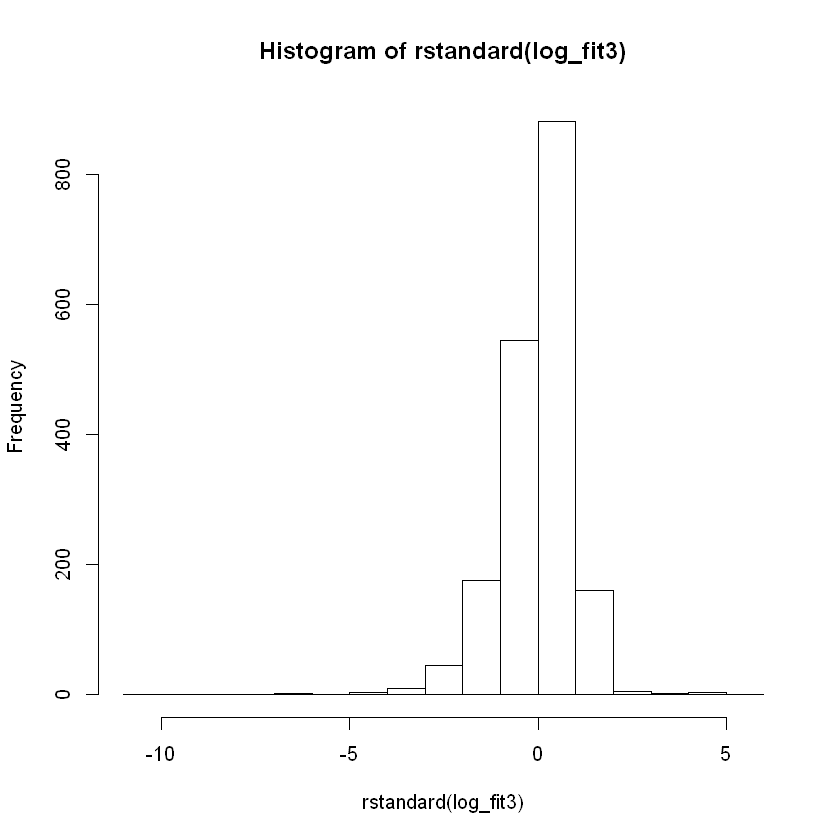

In [37]:
hist(rstandard(log_fit3))

## Predict the Validation Dataset
Our formula is:
`y-hat <- 0.689401 + (1.057403 * x1)`

In [38]:
predictMarketValue <- function(x1){
  return (0.689401 + (1.057403 * x1))
}

# Create a new column in validation called `Yhat` to store predictions from our formula.
validation$Yhat <- rep(0, nrow(validation))

# Predict Full Market Value each observation.
for(i in 1:nrow(validation)){
  egi <- validation$logEstimatedGrossIncome[i]
  validation$Yhat[i] <- predictMarketValue(egi)
}

# Show top 10 results.
head(validation)

#predictions <- predict(log_fit3, validation)

#validation$Yhat <- predictions

,ID,Neighborhood,BuildingClassification,TotalUnits,YearBuilt,GrossSqFt,EstimatedGrossIncome,GrossIncomePerSqFt,EstimatedExpense,ExpensePerSqFt,...,Boro,logTotalUnits,logGrossSqFt,logEstimatedGrossIncome,logGrossIncomePerSqFt,logEstimatedExpense,logExpensePerSqFt,logNetOperatingIncome,logFullMarketValue,Yhat
5,5,TRIBECA,R4-CONDOMINIUM,239,1985,219495,10004582,45.58,2783197,12.68,...,Manhattan,5.476464,12.29908,16.11855,3.819469,14.83911,2.540026,15.79256,17.81042,17.73321
7,7,TRIBECA,R4-CONDOMINIUM,109,1985,105000,4365900,41.58,1273650,12.13,...,Manhattan,4.691348,11.56172,15.28933,3.727619,14.05740,2.495682,14.94441,16.91607,16.85639
20,20,FINANCIAL,R4-CONDOMINIUM,13,1920,37236,1545666,41.51,439012,11.79,...,Manhattan,2.564949,10.52503,14.25097,3.725934,12.99228,2.467252,13.91685,15.93837,15.75841
23,23,FINANCIAL,R4-CONDOMINIUM,320,2005,477747,19864720,41.58,5795071,12.13,...,Manhattan,5.768321,13.07684,16.80446,3.727619,15.57252,2.495682,16.45953,18.48054,18.45848
24,24,FINANCIAL,R4-CONDOMINIUM,382,1914,648926,27436591,42.28,6820212,10.51,...,Manhattan,5.945421,13.38307,17.12739,3.744314,15.73540,2.352327,16.84160,18.86254,18.79995
28,28,FINANCIAL,R9-CONDOMINIUM,40,1920,65396,1493000,22.83,594600,9.09,...,Manhattan,3.688879,11.08822,14.21630,3.128075,13.29564,2.207175,13.70837,15.69848,15.72176


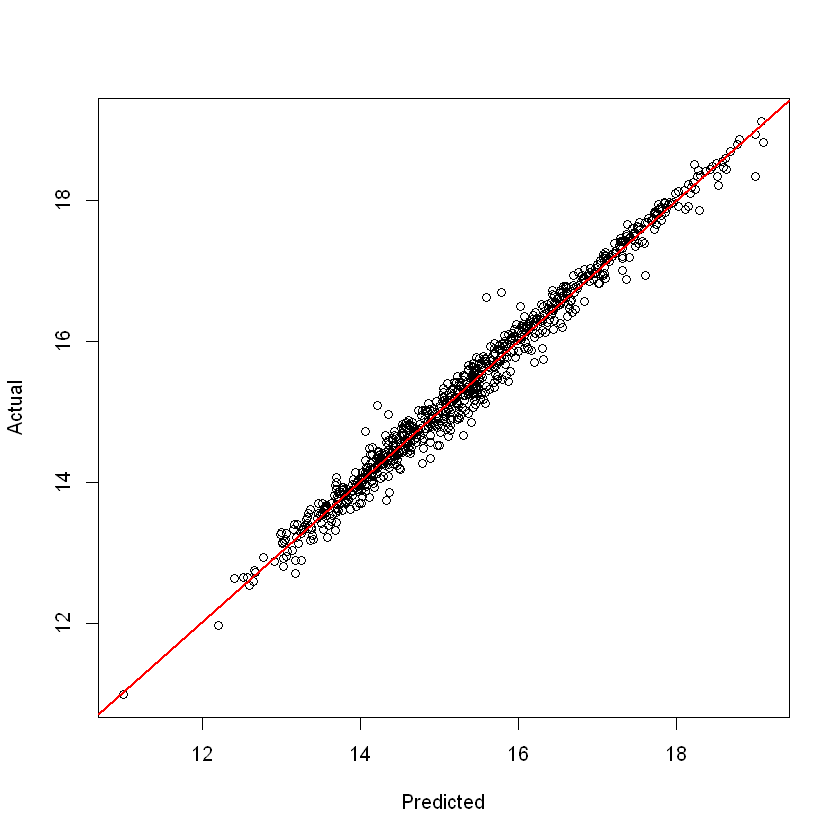

In [39]:
plot(validation$Yhat, validation$logFullMarketValue, xlab = "Predicted", ylab = "Actual")
abline(lm(logFullMarketValue ~ Yhat, data = validation), col = "red", lty=1, lwd=2)

# Export the validation set.
#write.csv(validation, "validation.csv")

## Multiple Linear Regression

### Convert Categorical Variables to Indicator Columns

### Add New Variable for Age (Feature Engineering)
Imputation of Missing (NA) Values
* There are NA values in the YearBuilt column.
* Determine if percentage of YearBuilt == NA is acceptable to replace with the mean.

In [40]:
nrows <- nrow(df)

# Get mean of YearBuilt excluding NA values.
missing_year_count <- nrow( filter(df, is.na(YearBuilt)) )
perc_missing <- missing_year_count / nrows * 100

print(paste("Missing", round(perc_missing, 2), "% of YearBuilt values."))

[1] "Missing 3.66 % of YearBuilt values."


In [41]:
# Impute missing values for YearBuilt
mean_year <- floor( mean(df$YearBuilt[!is.na(df$YearBuilt)]) )
current_year <- 2018

for(i in 1:nrow(df)){
    yr <- df$YearBuilt[i]
    age <- 0
    
    if(is.na(yr)){
        age <- current_year - mean_year
    } else {
        age <- current_year - yr
    }
    
    df$Age[i] <- age
}

head(df)

ID,Neighborhood,BuildingClassification,TotalUnits,YearBuilt,GrossSqFt,EstimatedGrossIncome,GrossIncomePerSqFt,EstimatedExpense,ExpensePerSqFt,...,Boro,logTotalUnits,logGrossSqFt,logEstimatedGrossIncome,logGrossIncomePerSqFt,logEstimatedExpense,logExpensePerSqFt,logNetOperatingIncome,logFullMarketValue,Age
1,FINANCIAL,R9-CONDOMINIUM,42,1920,36500,1332615,36.51,342005,9.37,...,Manhattan,3.737670,10.50507,14.10265,3.597586,12.74258,2.237513,13.80608,15.80338,98
2,FINANCIAL,R4-CONDOMINIUM,78,1985,126420,6633257,52.47,1762295,13.94,...,Manhattan,4.356709,11.74736,15.70761,3.960242,14.38213,2.634762,15.39880,17.23945,33
3,FINANCIAL,RR-CONDOMINIUM,500,NA,554174,17310000,31.24,3543000,6.39,...,Manhattan,6.214608,13.22523,16.66679,3.441699,15.08048,1.854734,16.43778,18.32604,51
4,FINANCIAL,R4-CONDOMINIUM,282,1930,249076,11776313,47.28,2784670,11.18,...,Manhattan,5.641907,12.42551,16.28160,3.856087,14.83964,2.414126,16.01181,18.02847,88
5,TRIBECA,R4-CONDOMINIUM,239,1985,219495,10004582,45.58,2783197,12.68,...,Manhattan,5.476464,12.29908,16.11855,3.819469,14.83911,2.540026,15.79256,17.81042,33
6,TRIBECA,R4-CONDOMINIUM,133,1986,139719,5127687,36.70,1497788,10.72,...,Manhattan,4.890349,11.84739,15.45017,3.602777,14.21950,2.372111,15.10472,17.10160,32


### Convert Categorical Variables to Indicator Columns

In [42]:
df_subset <- subset(df, select = -c(TotalUnits, YearBuilt, GrossSqFt, EstimatedGrossIncome, 
                                    GrossIncomePerSqFt, EstimatedExpense, ExpensePerSqFt, 
                                    NetOperatingIncome, FullMarketValue, MarketValuePerSqFt, 
                                    logGrossIncomePerSqFt, 
                                    logExpensePerSqFt, Neighborhood)) 

head(df_subset)

ID,BuildingClassification,Boro,logTotalUnits,logGrossSqFt,logEstimatedGrossIncome,logEstimatedExpense,logNetOperatingIncome,logFullMarketValue,Age
1,R9-CONDOMINIUM,Manhattan,3.737670,10.50507,14.10265,12.74258,13.80608,15.80338,98
2,R4-CONDOMINIUM,Manhattan,4.356709,11.74736,15.70761,14.38213,15.39880,17.23945,33
3,RR-CONDOMINIUM,Manhattan,6.214608,13.22523,16.66679,15.08048,16.43778,18.32604,51
4,R4-CONDOMINIUM,Manhattan,5.641907,12.42551,16.28160,14.83964,16.01181,18.02847,88
5,R4-CONDOMINIUM,Manhattan,5.476464,12.29908,16.11855,14.83911,15.79256,17.81042,33
6,R4-CONDOMINIUM,Manhattan,4.890349,11.84739,15.45017,14.21950,15.10472,17.10160,32


In [43]:
df2 <- dummy.data.frame(df_subset, names=c("Boro", "BuildingClassification"), sep="_")
names(df2) <- make.names(names(df2)) # remove special characters from column names
head(df2)

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"

ID,BuildingClassification_R2.CONDOMINIUM,BuildingClassification_R4.CONDOMINIUM,BuildingClassification_R9.CONDOMINIUM,BuildingClassification_RR.CONDOMINIUM,Boro_Bronx,Boro_Brooklyn,Boro_Manhattan,Boro_Queens,Boro_Staten.Island,logTotalUnits,logGrossSqFt,logEstimatedGrossIncome,logEstimatedExpense,logNetOperatingIncome,logFullMarketValue,Age
1,0,0,1,0,0,0,1,0,0,3.737670,10.50507,14.10265,12.74258,13.80608,15.80338,98
2,0,1,0,0,0,0,1,0,0,4.356709,11.74736,15.70761,14.38213,15.39880,17.23945,33
3,0,0,0,1,0,0,1,0,0,6.214608,13.22523,16.66679,15.08048,16.43778,18.32604,51
4,0,1,0,0,0,0,1,0,0,5.641907,12.42551,16.28160,14.83964,16.01181,18.02847,88
5,0,1,0,0,0,0,1,0,0,5.476464,12.29908,16.11855,14.83911,15.79256,17.81042,33
6,0,1,0,0,0,0,1,0,0,4.890349,11.84739,15.45017,14.21950,15.10472,17.10160,32


In [44]:
# Get training set
train_data <- df2[train_ind, ]
#write.csv(train_data, "train.csv")

# Get validation set
validation2 <- df2[-train_ind, ]
#write.csv(validation2, "validation.csv")

train_data <- subset(train_data, select = -c(ID, logNetOperatingIncome))

### Feature Selection with LASSO
* Least Absolute Shrinkage & Selection Operator
* Reg. Analys that performs feature selection
* Makes the model simpler and more interpretable
* Shrinks regression coefficients, with some shrunk to zero. Zero coefficients are removed (feature selection).
* Alpha values: LASSO = 1, Ridge = 0, Elastic Net = 0.5
https://www4.stat.ncsu.edu/~post/josh/LASSO_Ridge_Elastic_Net_-_Examples.html


In [45]:
# LASSO
lasso <- train(logFullMarketValue ~ .,
               data = train_data,
               tuneGrid = expand.grid(alpha=1, lambda = seq(0.0001, 0.2, length = 5)),
               method = "glmnet")

### Variable Importance
Shown in order of importance. Those equal to zero are not important.

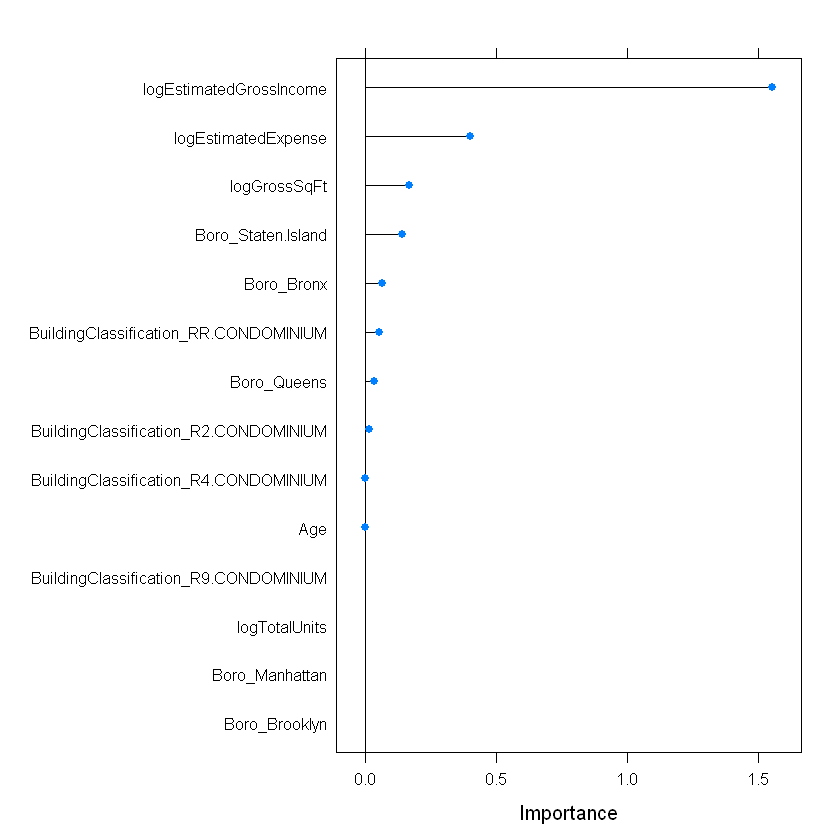

In [46]:
# Variable Importance plot
plot(varImp(lasso, scale=F))

In [47]:
# 0 or less is not important.
varImp(lasso)

glmnet variable importance

                                        Overall
logEstimatedGrossIncome               100.00000
logEstimatedExpense                    25.84755
logGrossSqFt                           10.80885
Boro_Staten.Island                      9.12602
Boro_Bronx                              4.18801
BuildingClassification_RR.CONDOMINIUM   3.51308
Boro_Queens                             2.13337
BuildingClassification_R2.CONDOMINIUM   1.03093
BuildingClassification_R4.CONDOMINIUM   0.07402
Age                                     0.02330
Boro_Brooklyn                           0.00000
logTotalUnits                           0.00000
Boro_Manhattan                          0.00000
BuildingClassification_R9.CONDOMINIUM   0.00000

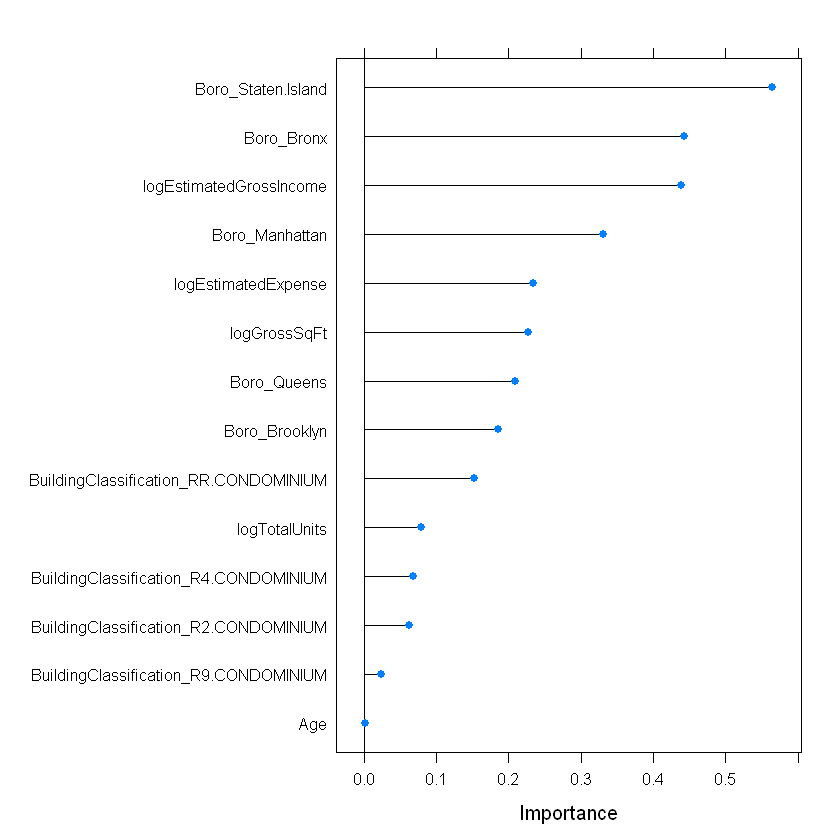

In [56]:
ridge <- train(logFullMarketValue ~ .,
               data = train_data,
               tuneGrid = expand.grid(alpha=0, lambda = seq(0.0001, 0.2, length = 5)),
               method = "glmnet")
# Variable Importance plot
plot(varImp(ridge, scale=F))

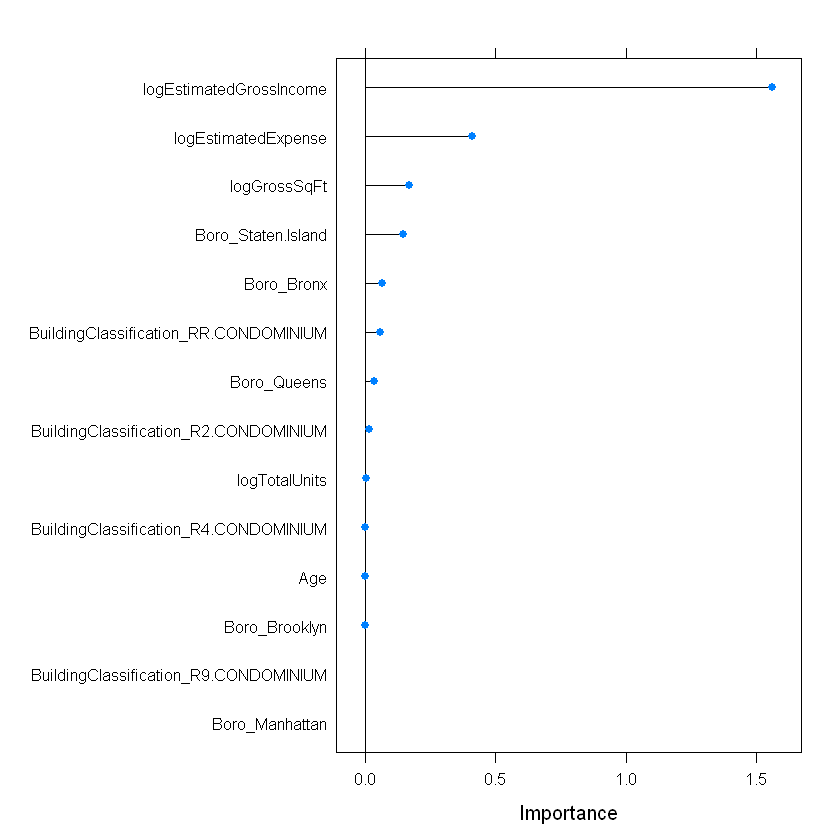

In [57]:
# Elastic Net
enet <- train(logFullMarketValue ~ .,
               data = train_data,
               tuneGrid = expand.grid(alpha=0.5, lambda = seq(0.0001, 0.2, length = 5)),
               method = "glmnet")
# Variable Importance plot
plot(varImp(enet, scale=F))

In [48]:
# Re-run linrar regression with the variables LASSO selected.
# Use variables that LASSO selected
lm2 <- train(logFullMarketValue ~ logEstimatedGrossIncome  + 
    logEstimatedExpense +
    Boro_Staten.Island +
    logGrossSqFt + 
    Boro_Bronx +
    BuildingClassification_RR.CONDOMINIUM + 
    Boro_Queens,
    data = train_data, 
    method = "lm")

In [49]:
summary(lm2$finalModel)
# All variables should have a p-value < 0.05 and are significant.


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.23551 -0.01757  0.02101  0.04706  1.16075 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                            0.716603   0.039146  18.306  < 2e-16 ***
logEstimatedGrossIncome                1.601833   0.013264 120.766  < 2e-16 ***
logEstimatedExpense                   -0.453225   0.019215 -23.587  < 2e-16 ***
Boro_Staten.Island                    -0.127317   0.034173  -3.726 0.000201 ***
logGrossSqFt                          -0.165112   0.015208 -10.857  < 2e-16 ***
Boro_Bronx                            -0.052556   0.020736  -2.534 0.011344 *  
BuildingClassification_RR.CONDOMINIUM -0.053959   0.022042  -2.448 0.014461 *  
Boro_Queens                           -0.023293   0.009557  -2.437 0.014895 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1359 on 1830 degrees

### Variance Inflation Factors (VIFs)
* Measures multicollinearity - variables that to highly related.
* Variables with a VIF > 10 will cause a model to be unstable. 
* Small changes in variable values will cause wild shifts in the model.
* Goal: remove or combine variables with VIF > 10

In [50]:
vif(lm2$finalModel)

logEstimatedGrossIncome                   logEstimatedExpense 
                            30.129526                             54.546142 
                   Boro_Staten.Island                          logGrossSqFt 
                             1.064377                             29.034305 
                           Boro_Bronx BuildingClassification_RR.CONDOMINIUM 
                             1.153753                              1.028812 
                          Boro_Queens 
                             1.273784

In [51]:
# Remove variables with high multicollinearity.
# Re-fit linear regression model.
lm3 <- train(logFullMarketValue ~ logEstimatedGrossIncome +
    Boro_Staten.Island +
    Boro_Bronx +
    BuildingClassification_RR.CONDOMINIUM + 
    Boro_Queens,
    data = train_data, 
    method = "lm")

vif(lm3$finalModel)
summary(lm3$finalModel)

logEstimatedGrossIncome                    Boro_Staten.Island 
                             1.055972                              1.003115 
                           Boro_Bronx BuildingClassification_RR.CONDOMINIUM 
                             1.012715                              1.012324 
                          Boro_Queens 
                             1.050347


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.14537 -0.09182  0.01822  0.11694  1.11006 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                            0.879393   0.049786  17.663  < 2e-16 ***
logEstimatedGrossIncome                1.045941   0.003537 295.682  < 2e-16 ***
Boro_Staten.Island                    -0.374536   0.047260  -7.925 3.93e-15 ***
Boro_Bronx                            -0.292427   0.027675 -10.566  < 2e-16 ***
BuildingClassification_RR.CONDOMINIUM -0.064896   0.031148  -2.083   0.0373 *  
Boro_Queens                           -0.123573   0.012363  -9.995  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1937 on 1832 degrees of freedom
Multiple R-squared:  0.9809,	Adjusted R-squared:  0.9809 
F-statistic: 1.882e+04 on 5 and 1832 DF,  p-value: < 2.2e-16


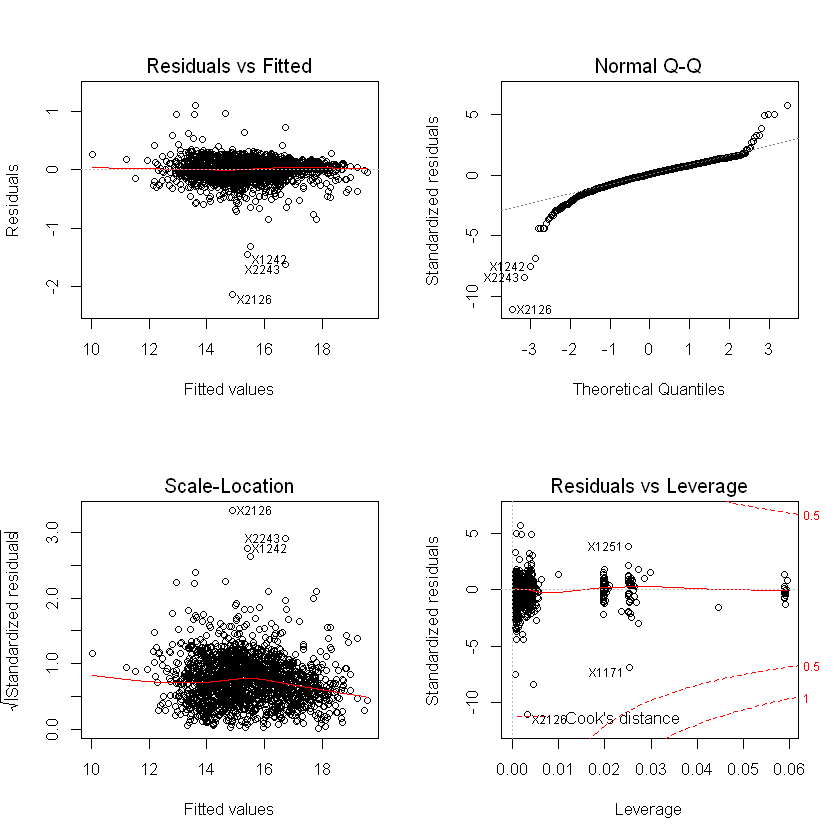

In [52]:
# Do we have a valid model?
par(mfrow=c(2,2))
plot(lm3$finalModel)

In [53]:
ncvTest(lm3$finalModel)
# p-value is not significant. Cosntant variance assumption seems to have been met.

Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 5.900268, Df = 1, p = 0.015139

### Do we have bad leverage points?

[1] "There are no points with a Cook's D > 1."


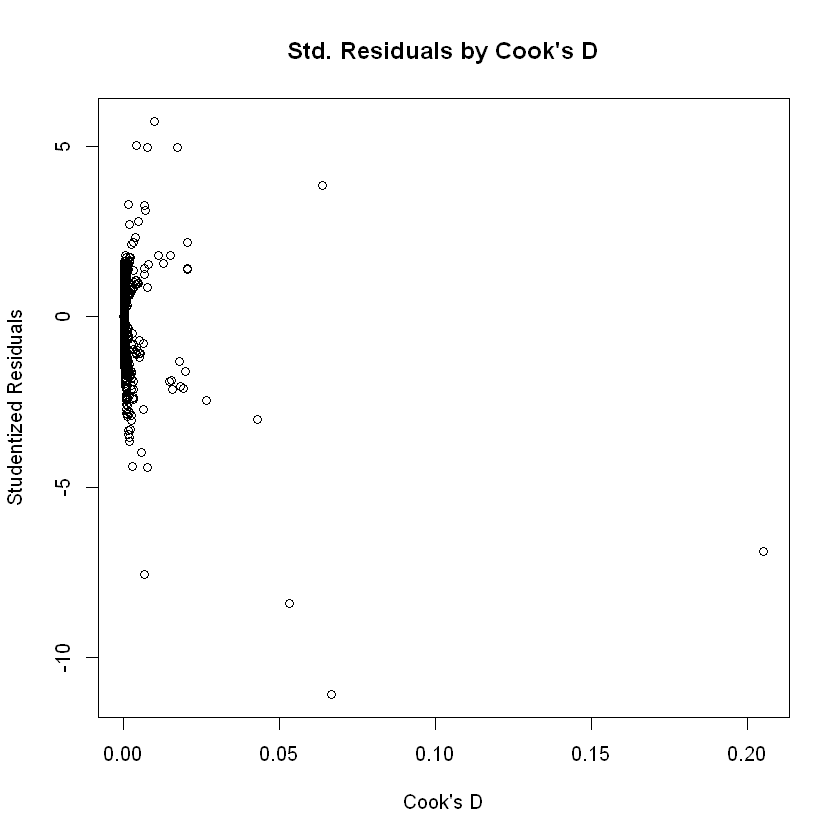

In [54]:
getCooksD(lm3$finalModel)

While there are clear outliers, none are overly influential; none have a Cook's Distance > 1 and removing them or adding a dummy variable for these observations will not significant change the estimated coefficient.

## Final Linear Regression Model Fit with Significant Variables

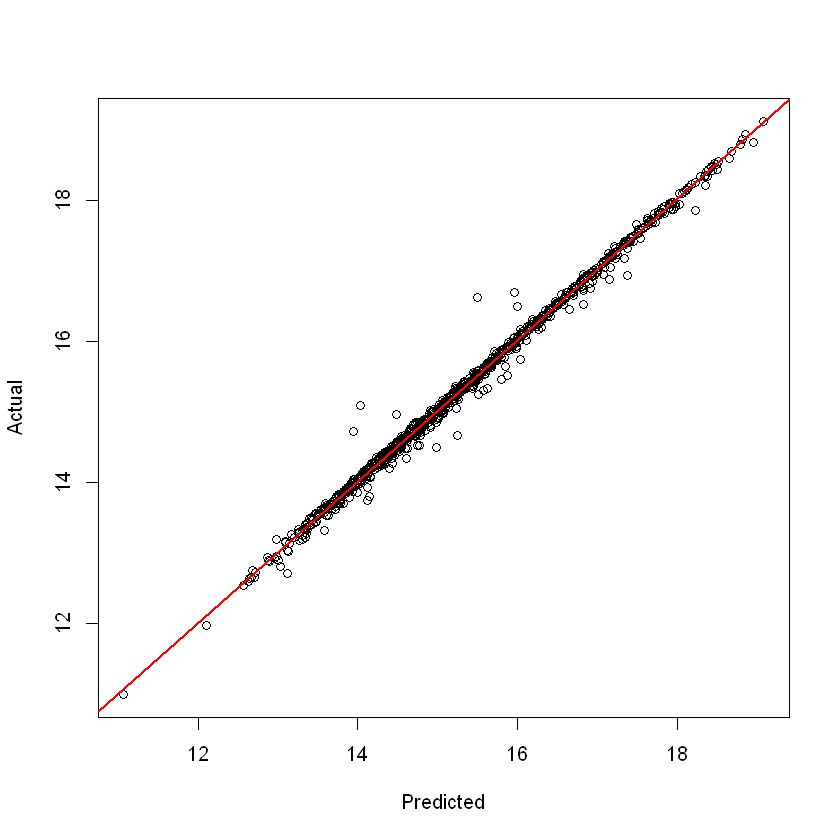

In [55]:
predicted <- predict(lm2, validation2)
validation2$Yhat <- predicted

plot(validation2$Yhat, validation2$logFullMarketValue, xlab = "Predicted", ylab = "Actual")
abline(lm(logFullMarketValue ~ Yhat, data = validation2), col = "red", lty=1, lwd=2)

## Model Interpretation
Because we log-transformed the reponse variable (Full Market Value), and the continuous predictor (Estimated Gross Income), the interpretation of the effect the coefficient has on the response variable is communicated in terms of percentage. 

In this case the coefficient for Log(EstimatedGrossIncome) is 1.047691. Therefore: 

**A 1% increase in Log(EstimatedGrossIncome) with a coefficient of 1.047691, is predicted to increase Log(FullMarketValue) by 1.048%.**

For the coefficients of the categorical variables, we must use the formula `exp(<coefficient>)-1` to reverse the log-transform of the response value. Then multiply the result by 100 for the percentage. In this case:

**For houses in Staten Island (coefficient = -0.374496), the Full Market Value is predicted to decrease by `(exp(-0.374496)-1) * 100` = -31.24%.**

**For houses in the Bronx (coefficient = -0.288601), the Full Market Value is predicted to decrease by `(exp(-0.288601)-1) * 100` = -25.07%.**

**For houses in Queens (coefficient = -0.117296), the Full Market Value is predicted to decrease by `(exp(-0.117296)-1) * 100` = -11.07%.**

**For RR Condominiums (coefficient = -0.051479), the Full Market Value is predicted to decrease by `(exp(-0.051479)-1) * 100` = -5.02%.**